In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 

import sklearn
from sklearn import model_selection 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import category_encoders as ce

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)

pd.options.mode.chained_assignment = None # default='warn'

## Part 0. Load data

In [337]:
# df = pd.read_json('transactions.zip', lines=True)
# df.replace('', np.nan, inplace=True)
# df.head(10)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.000,2016-08-13T14:27:32,98.550,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.000,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.000,2016-10-11T05:05:54,74.510,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.000,2016-11-08T09:18:39,7.470,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.000,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.000,2016-12-10T02:14:50,7.470,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.000,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.000,2016-03-24T21:04:46,71.180,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False
5,830329091,830329091,5000,5000.000,2016-04-19T16:24:27,30.760,In-N-Out #422833,US,US,02,01,fastfood,01/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False
6,830329091,830329091,5000,5000.000,2016-05-21T14:50:35,57.280,Krispy Kreme #685312,US,US,02,01,fastfood,05/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False
7,830329091,830329091,5000,5000.000,2016-06-03T00:31:21,9.370,Shake Shack #968081,US,US,05,01,fastfood,01/2021,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False
8,830329091,830329091,5000,4990.630,2016-06-10T01:21:46,523.670,Burger King #486122,NaN,US,02,01,fastfood,08/2032,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,9.370,NaN,NaN,NaN,True,NaN,NaN,False,False
9,830329091,830329091,5000,5000.000,2016-07-11T10:47:16,164.370,Five Guys #510989,US,US,05,08,fastfood,04/2020,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.000,NaN,NaN,NaN,True,NaN,NaN,False,False


In [2]:
print(df.isnull().sum())

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

In [ ]:
# df.to_pickle('data/trans_pickle')

In [313]:
df = pd.read_pickle('data/trans_pickle')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  object 
 10  posConditionCode          785954 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

## Part 1  Data Exploration

### 1.1 understand the raw data

#### Delete all NA columns and rows 

In [314]:
#df_1 = df.loc[:, (df.isnull().sum(axis=0) != 786363)] 
df_1 = df.dropna(axis=1, how = 'all')
df_1 = df_1.dropna(axis=0, how = 'all')

df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786363 entries, 0 to 786362
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  object 
 10  posConditionCode          785954 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [315]:
df_1['isFraud'].value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

#### Insight:

#### Considering minority class has more than 10k data, it can do down-sampling.

1. Split into training and test set first using stratified sampling technique, So test set keep original imbalanced distribution
2. Then do feature engineering (ratio feature engineering depending on true fraud/non-fraud distribution), 
3. Then right before training perform down-sampling only on training set


In [14]:
df_1.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,786363.000,786363.000,786363.000,786363.000,786363.000,786363.000,786363.000,786363.000,786363.000
mean,537232599.462,537232599.462,10759.464,6250.725,136.986,544.467,544.184,4757.418,4508.739
std,255421092.307,255421092.307,11636.175,8880.784,147.726,261.524,261.551,2996.584,6457.442
min,100088067.000,100088067.000,250.000,-1005.630,0.000,100.000,0.000,0.000,0.000
25%,330133277.000,330133277.000,5000.000,1077.420,33.650,310.000,310.000,2178.000,689.910
50%,507456073.000,507456073.000,7500.000,3184.860,87.900,535.000,535.000,4733.000,2451.760
75%,767620004.000,767620004.000,15000.000,7500.000,191.480,785.000,785.000,7338.000,5291.095
max,999389635.000,999389635.000,50000.000,50000.000,2011.540,998.000,998.000,9998.000,47498.810


#### delete/check duplicated transaction

In [15]:
df_1[df_1.duplicated(keep=False)]
# df_1.drop_duplicates(subset=None, keep='first', inplace = False).info()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud


### 1.2 understand the features

### 1.2.1 checking the numerical features

In [608]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_1.select_dtypes(include=numerics).columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionAmount', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'currentBalance'],
      dtype='object')

In [17]:
numerical_features = ['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
                    'transactionAmount', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'currentBalance']

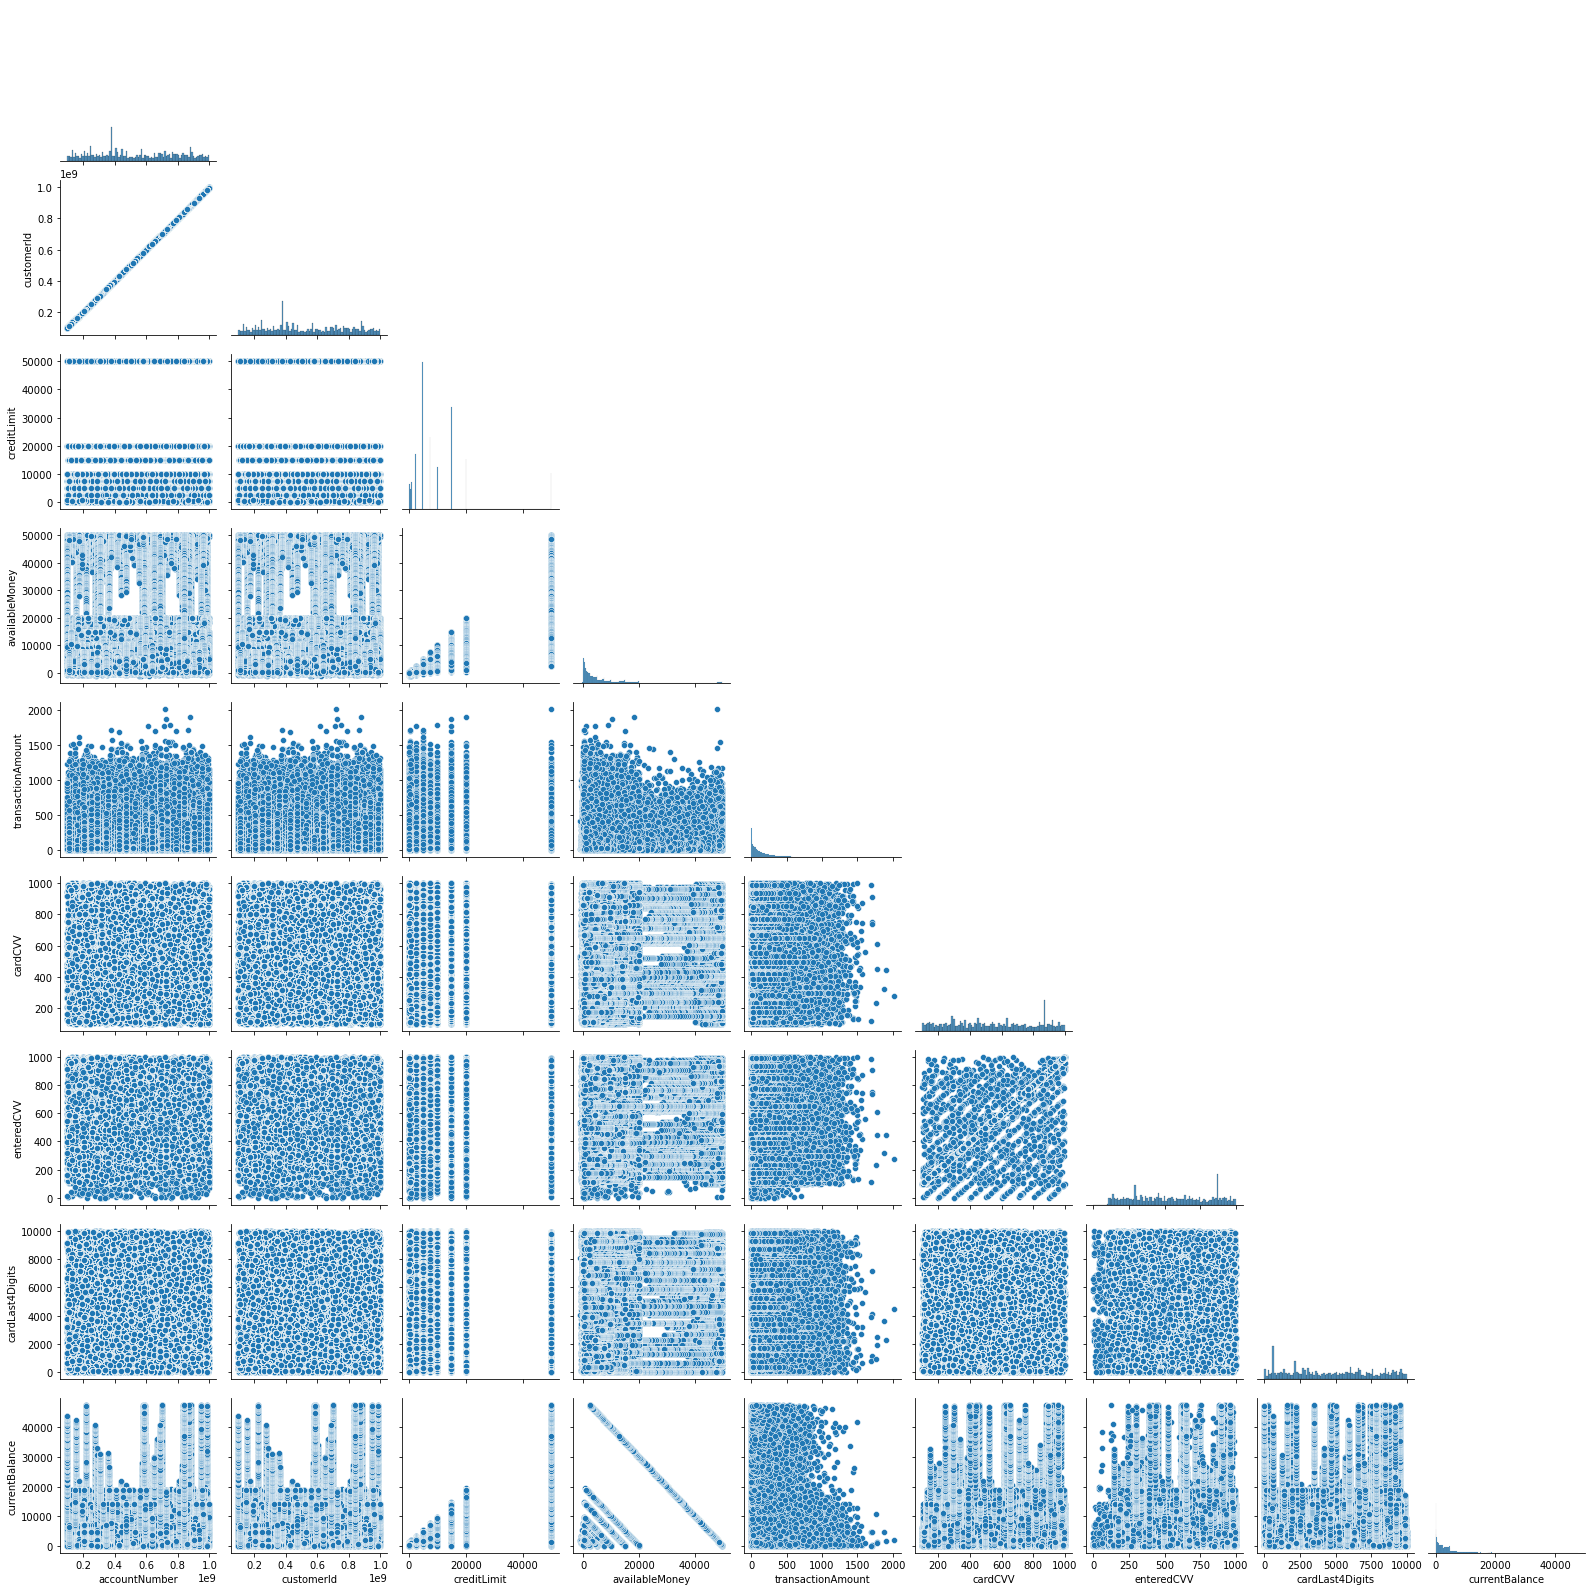

In [36]:
sns.pairplot(df_1[numerical_features], corner=True)
plt.show()

#### Findings: 
skewed feature: 'transactionAmount', 'currentBalance' (or 'availableMoney'), where currentBalance & availableMoney is correlated, keep only one of them.

'creditLimit' is discrete, it can be treated as categorical feature.

accountNumber & CustomerId is correlated, keep only one of them.

In [63]:
print('currentBalance + availableMoney == creditLimit: {},\
        \ncurrentBalance + availableMoney != creditLimit: {}'\
      .format(df_1[df_1['currentBalance']+df_1['availableMoney'] == df_1['creditLimit']].shape[0],\
    df_1[df_1['currentBalance']+df_1['availableMoney'] != df_1['creditLimit']].shape[0]))

currentBalance + availableMoney == creditLimit: 785314,        
currentBalance + availableMoney != creditLimit: 1049


#### Hypothesis to be validated:

1.any pattern in commiting fraud transaction when currentBalance + availableMoney != creditLimit?

2.any pattern in creditimit in commiting fraud transaction?

3.cardCVV and enteredCVV has different distribution, is there any clue for finding fraud transaction?

4.given typed cvv is correct or not, is the distribution of transactionAmount any difference in fraud transaction?

5.any pattern in transactionAmount in commiting fraud transaction?

6.any pattern in currentBalance in commiting fraud transaction?

7.any pattern in currentBalance/creditimit in commiting fraud transaction?

8.any pattern in transactionAmount/currentBalance in commiting fraud transaction?

9.any pattern in categorical feature: merchantCategoryCode, merchantName, posConditionCode in commiting fraud transaction?

10.is there any cluster found in fraud and non-fraud transaction?

### Log transform skewed feature

#### transactionAmount

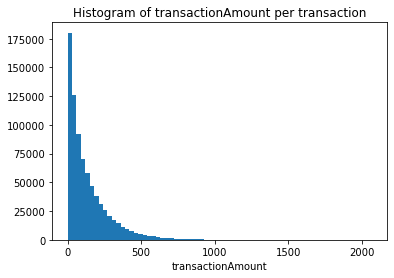

In [64]:
plt.hist(df_1['transactionAmount'],bins=range(0,2100,30) )
plt.title('Histogram of transactionAmount per transaction')

plt.xlabel('transactionAmount')
plt.show()

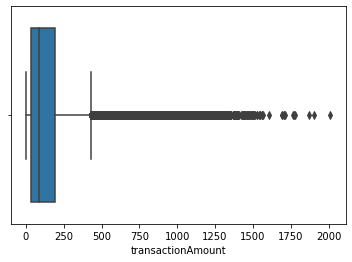

In [259]:
sns.boxplot(x= 'transactionAmount',data=df_1)
plt.show()

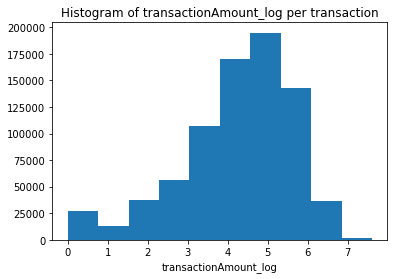

In [65]:
df_1['transactionAmount_log'] = np.log(df_1['transactionAmount']+1)

plt.hist(df_1['transactionAmount_log'])
plt.title('Histogram of transactionAmount_log per transaction')

plt.xlabel('transactionAmount_log')
plt.show()

#### availableMoney

<AxesSubplot:ylabel='Frequency'>

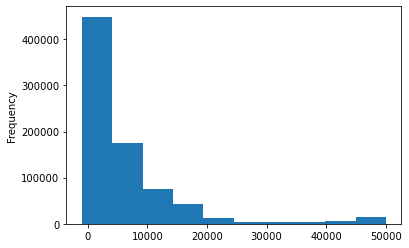

In [414]:
df_1['availableMoney'].plot.hist()

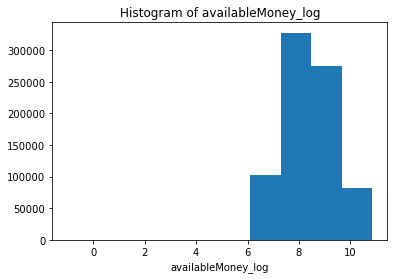

In [66]:
df_1['availableMoney_log'] = np.log(df_1['availableMoney']+1006)

plt.hist(df_1['availableMoney_log'])
plt.title('Histogram of availableMoney_log')

plt.xlabel('availableMoney_log')
plt.show()

In [67]:
df_1[df_1['currentBalance']+df_1['availableMoney'] != df_1['creditLimit']]\
    .groupby('isFraud').agg({'isFraud': 'count'}).rename_axis(index={'isFraud': 'currentBalance + availableMoney != creditLimit'})\
    .apply(lambda x: x/float(x.sum()))

,isFraud
currentBalance + availableMoney != creditLimit,
False,0.990
True,0.010


In [68]:
df_1[df_1['currentBalance']+df_1['availableMoney'] == df_1['creditLimit']]\
    .groupby('isFraud').agg({'isFraud': 'count'}).rename_axis(index={'isFraud': 'currentBalance + availableMoney == creditLimit'})\
    .apply(lambda x: x/float(x.sum()))

,isFraud
currentBalance + availableMoney == creditLimit,
False,0.984
True,0.016


#### Insight:
1.any pattern in commiting fraud transaction when currentBalance + availableMoney != creditLimit?

No obvious pattern.

#### currentBalance

<AxesSubplot:ylabel='Frequency'>

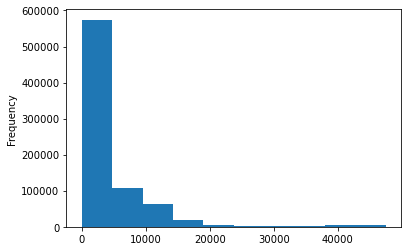

In [417]:
df_1['currentBalance'].plot.hist()

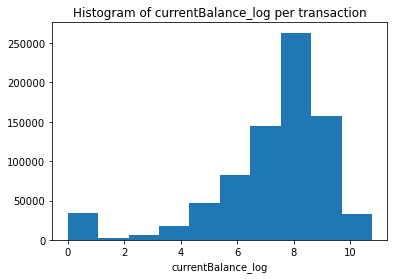

In [69]:
df_1['currentBalance_log'] = np.log(df_1['currentBalance']+1)

plt.hist(df_1['currentBalance_log'])
plt.title('Histogram of currentBalance_log per transaction')

plt.xlabel('currentBalance_log')
plt.show()

#### creditLimit

<AxesSubplot:ylabel='Frequency'>

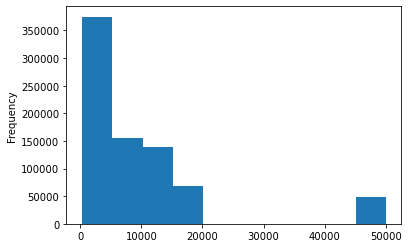

In [419]:
df_1['creditLimit'].plot.hist()

<AxesSubplot:xlabel='creditLimit'>

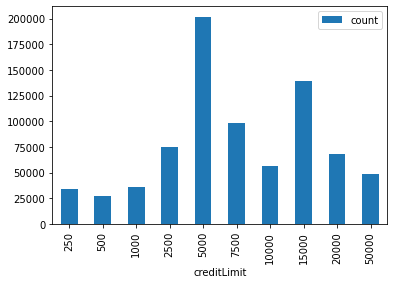

In [420]:
df_1.groupby('creditLimit').agg({'creditLimit':'count'})\
    .rename(columns={'creditLimit': 'count'})\
    .reset_index().astype({'creditLimit':'string'}).plot.bar(x='creditLimit', y='count')

In [70]:
df_1.groupby(['creditLimit', 'isFraud']).agg({'isFraud':'count'})\
    .rename(columns = {'isFraud':'isFraudValue'})\
    .groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))\
    .query('isFraud == True').reset_index().astype({'creditLimit':'string'})[['creditLimit', 'isFraudValue']]\
    .sort_values(by='isFraudValue')

,creditLimit,isFraudValue
0,250,1.196
5,7500,1.317
8,20000,1.332
6,10000,1.346
3,2500,1.480
2,1000,1.499
1,500,1.716
9,50000,1.724
4,5000,1.747
7,15000,1.827


<AxesSubplot:xlabel='creditLimit'>

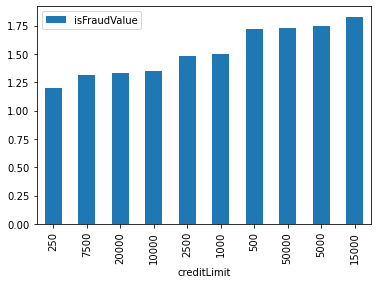

In [71]:
df_1.groupby(['creditLimit', 'isFraud']).agg({'isFraud':'count'})\
    .rename(columns = {'isFraud':'isFraudValue'})\
    .groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))\
    .query('isFraud == True').reset_index().astype({'creditLimit':'string'})[['creditLimit', 'isFraudValue']]\
    .sort_values(by='isFraudValue').plot.bar(x='creditLimit', y='isFraudValue', stacked=True)

#### Insight:

2.any pattern in creditimit in commiting fraud transaction?

250	gives the lowest possibility of committing fraud transaction with number around 1.2;
whilst 15000 gives the highest possibility with number around 1.8.


#### 'balance_limit_ratio' = Current balance / Credit limit 

In [72]:
df_1['balance_limit_ratio'] = df_1['currentBalance']/df_1['creditLimit']
df_1['balance_limit_ratio_log'] = np.log(df_1['balance_limit_ratio']+1)

In [27]:
df_1.iloc[[df_1['balance_limit_ratio'].argmax()]]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio,balance_limit_ratio_log
357268,285133306,285133306,250,-930.550,2016-11-14T03:28:07,195.390,Uptown Steakhouse,US,US,02,08,food,12/2029,2009-07-30,2016-11-08,830,830,5019,PURCHASE,1180.550,True,False,False,5.280,4.323,7.075,4.722,1.744


#### 'transaction_balance_ratio' = transactionAmount_log / currentBalance_log

In [73]:
df_1['transaction_balance_ratio'] = df_1['transactionAmount_log']/(df_1['currentBalance_log']+1)
df_1['transaction_balance_ratio_log'] = np.log(df_1['transaction_balance_ratio']+1)

In [29]:
df_1.iloc[[df_1['transaction_balance_ratio'].argmax()]]

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio,balance_limit_ratio_log,transaction_balance_ratio,transaction_balance_ratio_log
501537,788948518,788948518,15000,15000.000,2016-12-01T21:07:03,1693.360,Shake Shack #235531,US,US,09,01,fastfood,05/2022,2014-12-05,2016-06-29,115,115,787,PURCHASE,0.000,True,False,False,7.435,9.681,0.000,0.000,0.000,7.435,2.132


#### check the real card CVV and entered CVV :'CVV_correct' 

In [74]:
df_1['CVV_correct'] = np.where( df_1['cardCVV'] == df_1['enteredCVV'], True, False)

In [75]:
df_1.query('cardCVV != enteredCVV')[['isFraud']]\
    .groupby('isFraud').agg({'isFraud': 'count'})\
    .rename(columns = {'isFraud': 'cardCVV  != enteredCVV'})\
    .apply(lambda x: x / float(x.sum()))

,cardCVV != enteredCVV
isFraud,
False,0.971
True,0.029


In [76]:
df_1.query('cardCVV == enteredCVV')[['isFraud']]\
    .groupby('isFraud').agg({'isFraud': 'count'})\
    .rename(columns = {'isFraud': 'cardCVV  == enteredCVV'})\
    .apply(lambda x: x / float(x.sum()))

,cardCVV == enteredCVV
isFraud,
False,0.984
True,0.016


#### Insight

3.cardCVV and enteredCVV has different distribution, is there any clue for finding fraud transation?

When cardCVV  != enteredCVV, it has almost as two times as risky of being fraud transaction compared to cardCVV  == enteredCVV

#### transaction | CVV_correct 

In [32]:
df_1.query('cardCVV != enteredCVV')[['transactionAmount_log', 'isFraud']].head()

,transactionAmount_log,isFraud
19,5.284,False
100,5.133,False
101,5.133,False
211,5.696,False
261,6.509,False


isFraud
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: transactionAmount_log, dtype: object

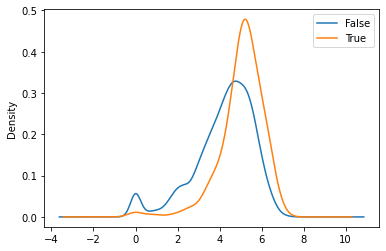

In [33]:
df_1.query('cardCVV != enteredCVV')[['transactionAmount_log', 'isFraud']]\
    .groupby(['isFraud'])['transactionAmount_log']\
    .plot.kde(legend=True)

isFraud
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: transactionAmount_log, dtype: object

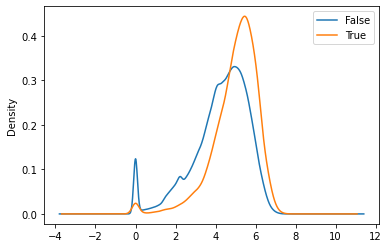

In [34]:
df_1.query('cardCVV == enteredCVV')[['transactionAmount_log', 'isFraud']]\
    .groupby(['isFraud'])['transactionAmount_log']\
    .plot.kde(legend=True)

#### Insight:

4.given typed cvv is correct or not, is the distribution of transactionAmount any difference in fraud transaction?

CVV_correct is indicative, as the fraud transaction tends to occur when cvv is not correctly typed, even their transaction distributions look similar.

### Differences in the distribution of skewed feature against target (fraud-nonfraud)

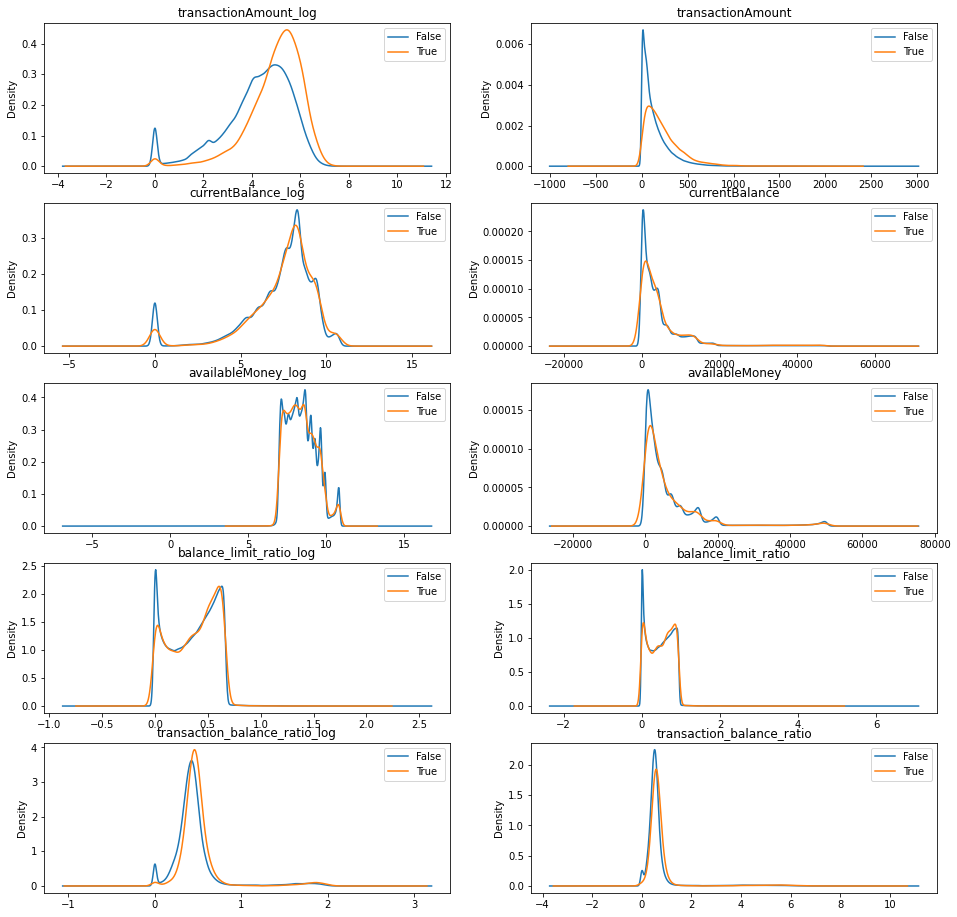

In [627]:
value_list = ['transactionAmount_log','transactionAmount', 
              'currentBalance_log', 'currentBalance', 
              'availableMoney_log', 'availableMoney',
              'balance_limit_ratio_log', 'balance_limit_ratio',
              'transaction_balance_ratio_log', 'transaction_balance_ratio']

fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(16, 16))

for index, value in enumerate(value_list):
    df_1.groupby(['isFraud'])[value].plot.kde(ax=ax[index//2][index%2], legend=True)
    ax[index//2][index%2].set_title(value)


plt.show()

#### insight:

5.any pattern in transactionAmount in commiting fraud transaction?

transactionAmount_log = {0, 5, 6} tends to be a strong indication for being fraud.
<br>
<br>

6.any pattern in currentBalance in commiting fraud transaction?

currentBalance_log = {0, 8} tends to be a strong indication for being fraud. 
<br>
<br>

7.any pattern in currentBalance/creditLimit in commiting fraud transaction?

currentBalance/creditLimit = 0 tends to be a strong indication for being fraud. 
<br>
<br>

8.any pattern in transactionAmount/currentBalance in commiting fraud transaction?

transactionAmount/currentBalance = 0 tends to be a strong indication for being fraud. 
<br>
<br>

Above features can use Binning technique to encode.
<br>
<br>

*Since currentBalance & availableMoney are correlated and currentBalance_log is more indicative than availableMoney_log, keep currentBalance & currentBalance_log, drop availableMoney & availableMoney_log.*

### Differences in the distribution of skewed feature against target (fraud-nonfraud)

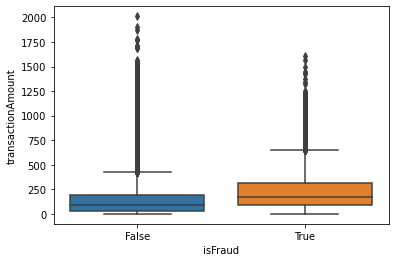

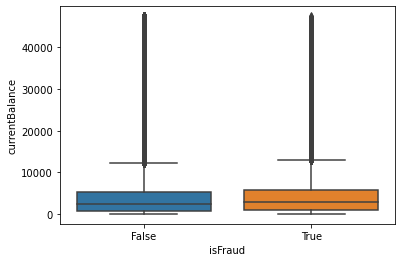

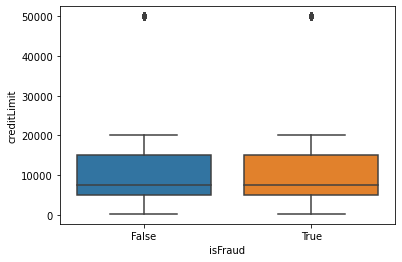

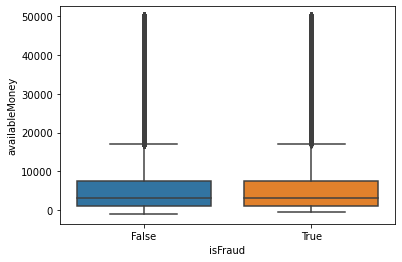

In [265]:
value_list = ['transactionAmount','currentBalance', 'creditLimit','availableMoney']
for value in value_list:
    sns.boxplot(y= value,x= 'isFraud', data=df_1)
    plt.show()
    

from the above continuous variable disribution analysis, the fraud transaction usually has higher transactionAmount with the median transactionAmount is around 200. 

#### The duriation between account open date and transaction date 

In [35]:
df_1['days_after_signup'] = (pd.to_datetime(df_1['transactionDateTime']) - pd.to_datetime(df_1['accountOpenDate'])).astype('timedelta64[D]')

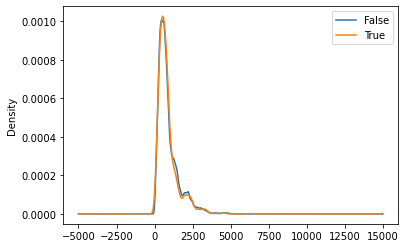

In [36]:
df_1.groupby(['isFraud'])['days_after_signup'].plot.kde()
plt.legend()

### correlation among numerical features

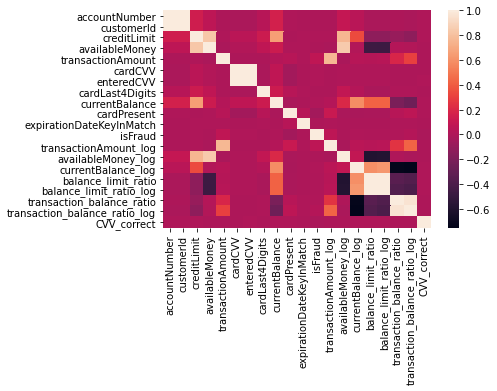

In [77]:
corr_list= df_1.corr()
sns.heatmap(corr_list)
plt.show()

In [78]:
corr_list

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio,balance_limit_ratio_log,transaction_balance_ratio,transaction_balance_ratio_log,CVV_correct
accountNumber,1.000,1.000,0.141,0.066,-0.001,-0.011,-0.011,0.039,0.162,0.006,-0.001,-0.004,-0.002,0.096,0.047,-0.012,-0.011,-0.005,-0.011,0.005
customerId,1.000,1.000,0.141,0.066,-0.001,-0.011,-0.011,0.039,0.162,0.006,-0.001,-0.004,-0.002,0.096,0.047,-0.012,-0.011,-0.005,-0.011,0.005
creditLimit,0.141,0.141,1.000,0.835,0.006,0.051,0.051,0.126,0.654,-0.004,0.002,0.003,0.006,0.759,0.339,-0.124,-0.127,-0.093,-0.127,0.001
availableMoney,0.066,0.066,0.835,1.000,-0.010,0.016,0.016,0.074,0.129,0.003,0.004,-0.002,-0.012,0.848,0.018,-0.467,-0.476,0.027,0.017,-0.001
transactionAmount,-0.001,-0.001,0.006,-0.010,1.000,-0.000,-0.000,-0.002,0.024,0.037,0.002,0.076,0.765,-0.013,0.040,0.035,0.037,0.188,0.300,0.001
cardCVV,-0.011,-0.011,0.051,0.016,-0.000,1.000,0.996,-0.012,0.070,-0.045,-0.000,0.009,-0.001,0.006,0.006,0.008,0.007,0.001,0.000,-0.003
enteredCVV,-0.011,-0.011,0.051,0.016,-0.000,0.996,1.000,-0.011,0.070,-0.045,-0.000,0.009,-0.001,0.006,0.006,0.008,0.008,0.001,-0.000,0.008
cardLast4Digits,0.039,0.039,0.126,0.074,-0.002,-0.012,-0.011,1.000,0.125,0.041,0.002,0.001,-0.002,0.083,0.024,-0.018,-0.019,0.007,0.002,-0.001
currentBalance,0.162,0.162,0.654,0.129,0.024,0.070,0.070,0.125,1.000,-0.011,-0.001,0.008,0.027,0.201,0.587,0.419,0.425,-0.204,-0.252,0.003
cardPresent,0.006,0.006,-0.004,0.003,0.037,-0.045,-0.045,0.041,-0.011,1.000,0.040,-0.043,0.115,-0.007,-0.014,-0.010,-0.010,0.040,0.066,0.003


In [82]:
# Create correlation matrix
corr_matrix = corr_list.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
cor_features = [column for column in upper.columns if any(upper[column] > 0.9)]
cor_features

['customerId',
 'enteredCVV',
 'balance_limit_ratio_log',
 'transaction_balance_ratio_log']

#### Summary:
from above correlation analysis, we can tell there is correlation among:

cusomerId ~ accountNumber,

enteredCVV ~ cardCVV,

balance_limit_ratio_log ~ balance_limit_ratio,

transaction_balance_ratio_log ~ transaction_balance_ratio,
 
currentBalance_log is more indicative than availableMoney_log, keep currentBalance & currentBalance_log, drop availableMoney

#### Drop some unwanted columns

In [83]:
df_1 = df_1.drop(['accountNumber', 'customerId', 'cardLast4Digits', 'cardCVV','enteredCVV',
                  'availableMoney', 'balance_limit_ratio', 'transaction_balance_ratio'], axis = 1)  

### checking datetime features

In [85]:
datetime_features = ['currentExpDate','accountOpenDate','transactionDateTime', 'dateOfLastAddressChange']


In [274]:
currentExpDatefreq = df_1.groupby(['currentExpDate', 'isFraud']).agg({'isFraud': 'count'})\
    .groupby(level=0).apply(lambda x: x / float(x.sum()))

accountOpenDatefreq = df_1.groupby(['accountOpenDate', 'isFraud']).agg({'isFraud': 'count'})\
    .groupby(level=0).apply(lambda x: x / float(x.sum()))

transactionDateTimefreq = df_1.groupby(['transactionDateTime', 'isFraud']).agg({'isFraud': 'count'})\
    .groupby(level=0).apply(lambda x: x / float(x.sum()))

dateOfLastAddressChangefreq = df_1.groupby(['dateOfLastAddressChange', 'isFraud']).agg({'isFraud': 'count'})\
    .groupby(level=0).apply(lambda x: x / float(x.sum()))

Text(0.5, 1.0, 'changes of isFraud_ratio with date')

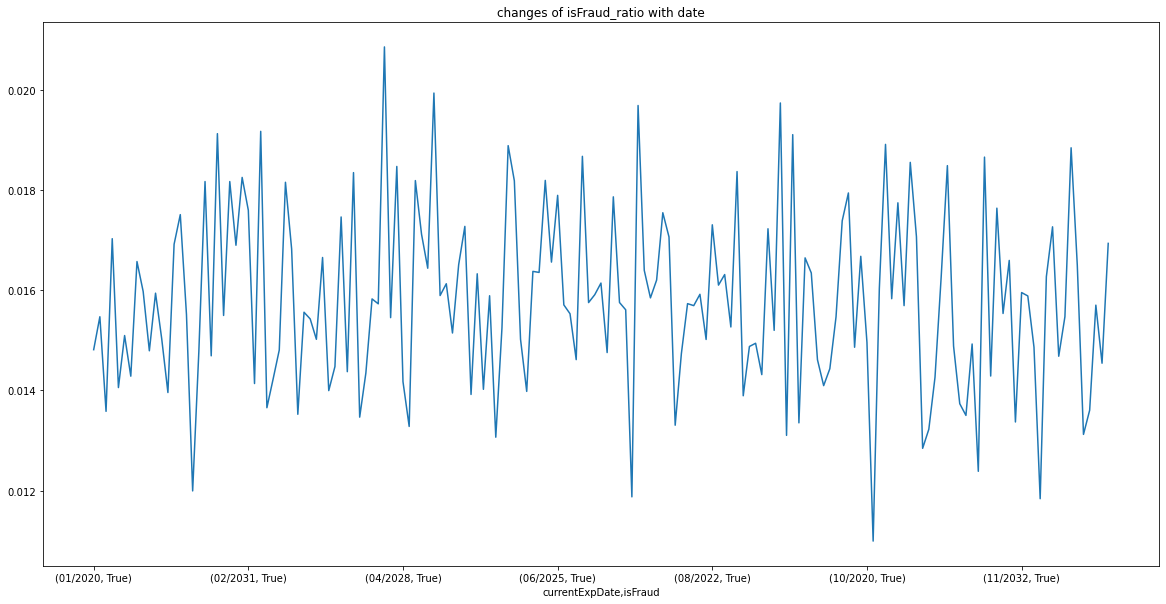

In [282]:
currentExpDatefreq.loc[currentExpDatefreq.index.get_level_values('isFraud')==True]['isFraud'].plot(figsize=(20, 10))
plt.title('changes of isFraud_ratio with date')

Text(0.5, 1.0, 'changes of isFraud_ratio with date')

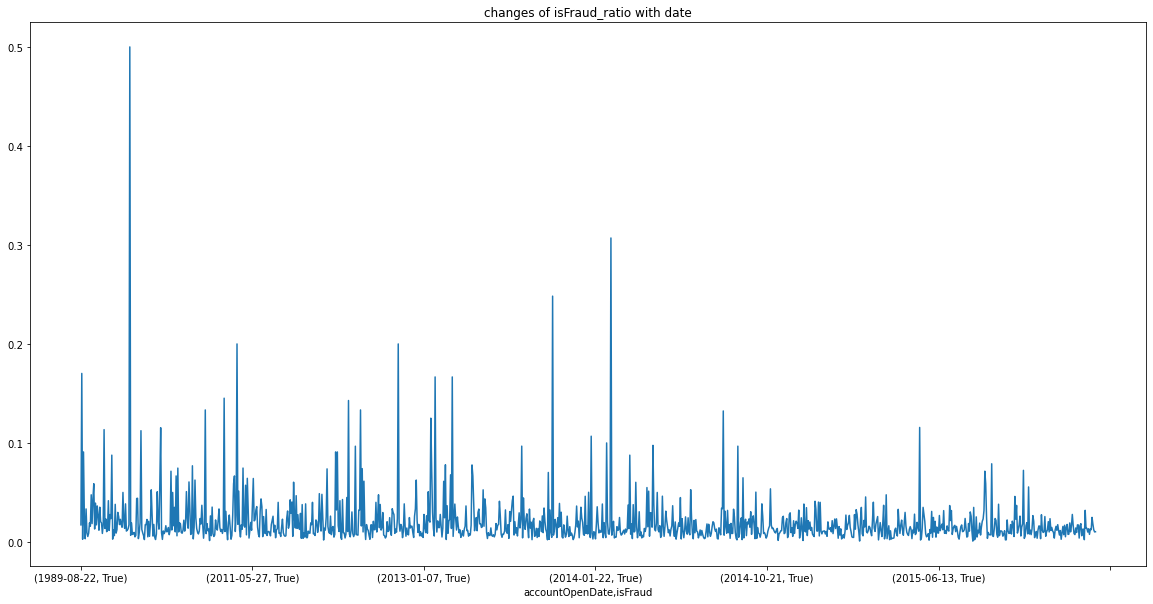

In [283]:
accountOpenDatefreq.loc[accountOpenDatefreq.index.get_level_values('isFraud')==True]['isFraud'].plot(figsize=(20, 10))
plt.title('changes of isFraud_ratio with date')

Text(0.5, 1.0, 'changes of isFraud_ratio with date')

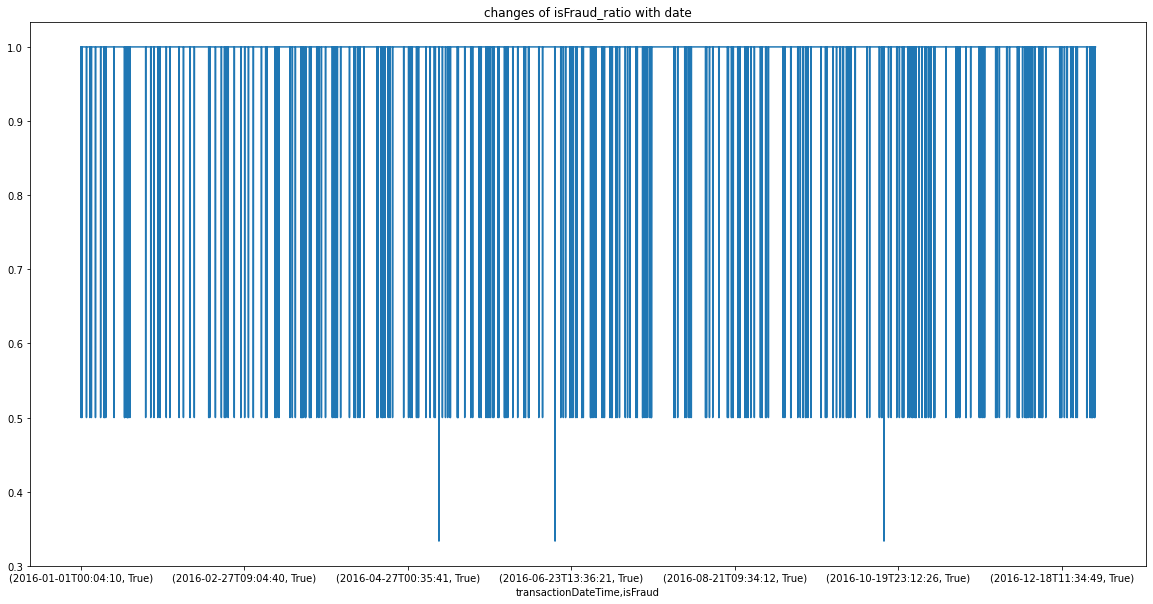

In [284]:
transactionDateTimefreq.loc[transactionDateTimefreq.index.get_level_values('isFraud')==True]['isFraud'].plot(figsize=(20, 10))
plt.title('changes of isFraud_ratio with date')

Text(0.5, 1.0, 'changes of isFraud_ratio with date')

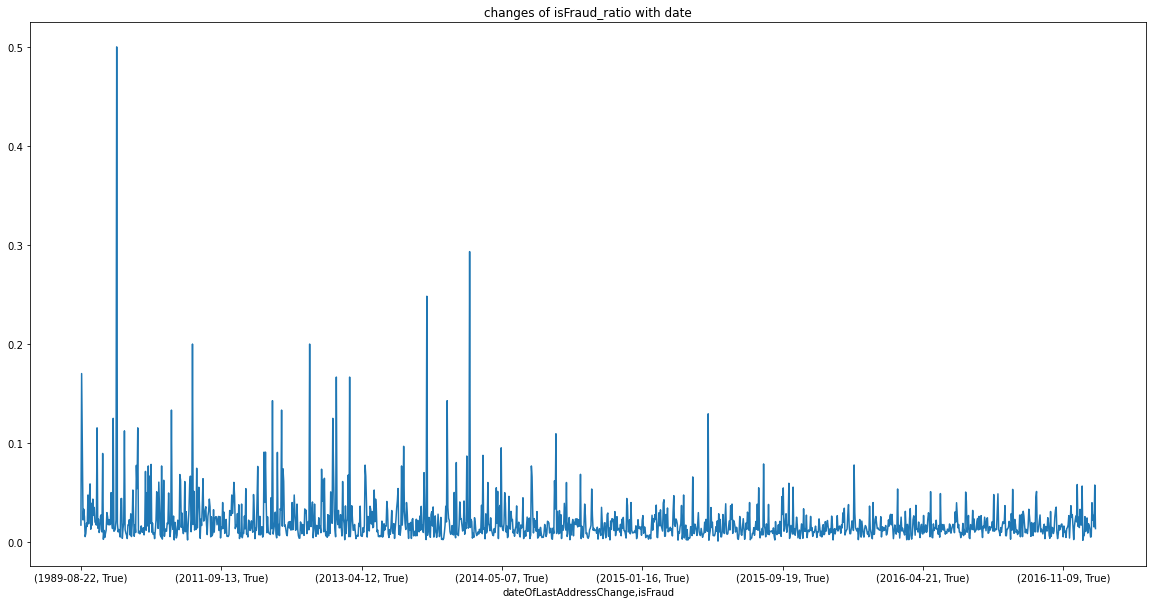

In [285]:
dateOfLastAddressChangefreq.loc[dateOfLastAddressChangefreq.index.get_level_values('isFraud')==True]['isFraud'].plot(figsize=(20, 10))
plt.title('changes of isFraud_ratio with date')

#### Insight:
currentExpDate doesn't have strong indication for being fraud.

certain dates in features: accountOpenDate, dateOfLastAddressChange show strong tendency for being fraud.

### 1.2.2 checking the categorical features against being fraud

In [86]:
categorical_features = list(set(df_1.columns) - set(df_1._get_numeric_data().columns) \
                            - set(datetime_features))
categorical_features

['acqCountry',
 'transactionType',
 'posConditionCode',
 'merchantCountryCode',
 'posEntryMode',
 'merchantCategoryCode',
 'merchantName']

#### acqCountry against being fraud

In [87]:
df_1['acqCountry'].value_counts(), df_1['acqCountry'].nunique()

(US     774709
 MEX      3130
 CAN      2424
 PR       1538
 Name: acqCountry, dtype: int64,
 4)

In [88]:
df_1.groupby(['acqCountry','isFraud']).agg({'isFraud': 'count'})

isFraud
acqCountry isFraud         
CAN        False       2369
           True          55
MEX        False       3066
           True          64
PR         False       1511
           True          27
US         False     762587
           True       12122

In [89]:
df_1.groupby(['acqCountry','isFraud']).agg({'isFraud': 'count'})\
    .rename_axis(index={'isFraud': 'isFraudValue'})\
    .groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))\
    .reset_index().query('isFraudValue == True')[['acqCountry', 'isFraud']]\
    .sort_values([('isFraud')], ascending=False)

,acqCountry,isFraud
1,CAN,2.269
3,MEX,2.045
5,PR,1.756
7,US,1.565


<AxesSubplot:xlabel='acqCountry'>

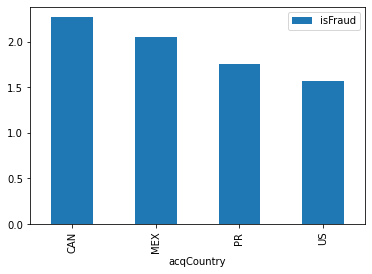

In [90]:
df_1.groupby(['acqCountry','isFraud']).agg({'isFraud': 'count'})\
    .rename_axis(index={'isFraud': 'isFraudValue'})\
    .groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))\
    .reset_index().query('isFraudValue == True')[['acqCountry', 'isFraud']]\
    .sort_values([('isFraud')], ascending=False)\
    .plot.bar(x='acqCountry', y='isFraud')

<AxesSubplot:xlabel='merchantCountryCode'>

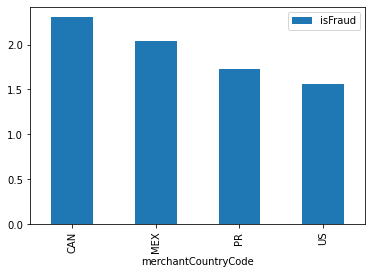

In [91]:
df_1.groupby(['merchantCountryCode','isFraud']).agg({'isFraud': 'count'})\
    .rename_axis(index={'isFraud': 'isFraudValue'})\
    .groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))\
    .reset_index().query('isFraudValue == True')[['merchantCountryCode', 'isFraud']]\
    .sort_values([('isFraud')], ascending=False)\
    .plot.bar(x='merchantCountryCode', y='isFraud')

In [95]:
df_1[df_1['merchantCountryCode']!=df_1['acqCountry']]\
    .groupby('isFraud').agg({'isFraud': 'count'})\
    .rename_axis(index={'isFraud': 'merchantCountryCode != acqCountry'})\
    .apply(lambda x: x/float(x.sum()))

,isFraud
merchantCountryCode != acqCountry,
False,0.968
True,0.032


In [96]:
df_1[df_1['merchantCountryCode']==df_1['acqCountry']]\
    .groupby('isFraud').agg({'isFraud': 'count'})\
    .rename_axis(index={'isFraud': 'merchantCountryCode == acqCountry'})\
    .apply(lambda x: x/float(x.sum()))

,isFraud
merchantCountryCode == acqCountry,
False,0.984
True,0.016


#### Insight:

When acqCountry != merchantCountryCode, there are two times higher for fradu transaction.

In [97]:
df_1['domesticTransaction'] = np.where( df_1['merchantCountryCode'] == df_1['acqCountry'], True, False)
df_1 = df_1.drop(['merchantCountryCode'], axis = 1)

#### all categorical features against being fraud

In [530]:
for col in categorical_features:
#     print(df_1.groupby([col,'isFraud']).agg({'isFraud': 'count'})\
#          .groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))\
#          .unstack('isFraud').fillna(0))
    print(df_1.groupby([col,'isFraud']).agg({'isFraud': 'count'})\
    .rename_axis(index={'isFraud': 'isFraudValue'})\
    .groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))\
    .reset_index().query('isFraudValue == True')[[col, 'isFraud']]\
    .sort_values([('isFraud')], ascending=False))

   merchantCategoryCode  isFraud
1               airline    3.465
29            rideshare    2.487
24        online_retail    2.443
22         online_gifts    2.425
14            furniture    1.386
10                 food    1.343
3                  auto    1.261
6         entertainment    1.200
8              fastfood    0.958
31        subscriptions    0.943
19               hotels    0.733
17               health    0.471
27        personal care    0.453
                        merchantName  isFraud
1390                In-N-Out #949129   11.236
78                 American Airlines    9.398
1382                In-N-Out #863086    9.375
1329                In-N-Out #463194    8.333
1325                In-N-Out #422833    8.182
1337                In-N-Out #567597    7.865
3240               Walgreens #475572    7.143
1295                 In-N-Out #17755    6.863
904                    Fresh Flowers    6.635
1386                In-N-Out #899468    6.604
1376                In-N-Out #81

        transactionType  isFraud
5              REVERSAL    1.660
3              PURCHASE    1.604
1  ADDRESS_VERIFICATION    0.575
  merchantCountryCode  isFraud
1                 CAN    2.308
3                 MEX    2.036
5                  PR    1.732
7                  US    1.566
   creditLimit_str  isFraud
5            15000    1.827
15            5000    1.747
17           50000    1.724
13             500    1.716
1             1000    1.499
11            2500    1.480
3            10000    1.346
7            20000    1.332
19            7500    1.317
9              250    1.196
  posConditionCode  isFraud
5               99    3.040
1               01    1.627
3               08    1.294
  posEntryMode  isFraud
5           09    2.393
9           90    1.900
1           02    1.746
7           80    1.570
3           05    0.780


#### insight: 

feaures like merchantCategoryCode, merchantName, posConditionCode have indication for being fraud, especially the merchantName has strong indication for being fraud

See below to split merchantName by '#' so we can reduce merchantName 

In [98]:
df_1['merchantName'] = df_1['merchantName'].str.split(' #').str[0]
df_1['merchantName'].head(10)

0            Uber
1             AMC
2      Play Store
3      Play Store
4     Tim Hortons
5        In-N-Out
6    Krispy Kreme
7     Shake Shack
8     Burger King
9       Five Guys
Name: merchantName, dtype: object

In [ ]:
### check the values for each categorical features 

col_list = [ 'acqCountry','creditLimit','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','transactionType',
            'cardPresent','expirationDateKeyInMatch']

for col in col_list:
    x = df_1[df_1['isFraud']== True][col].value_counts()
    print('col :',col,'the value counts is \n',x )

C:\Users\Weijia\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


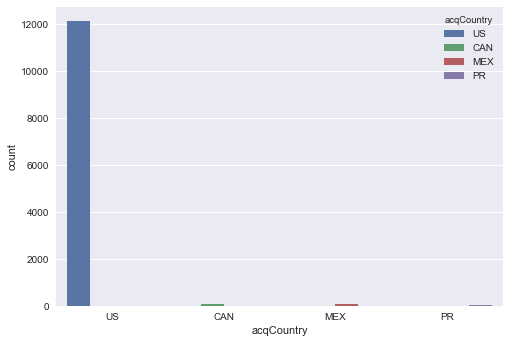

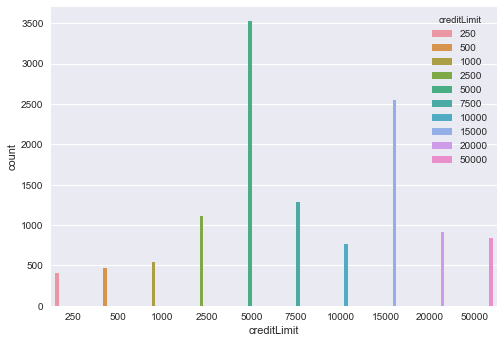

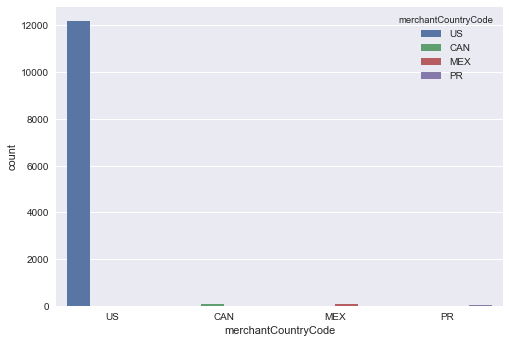

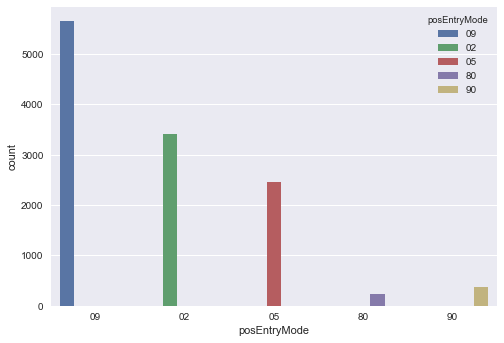

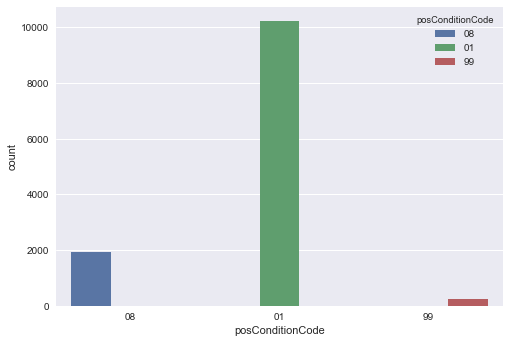

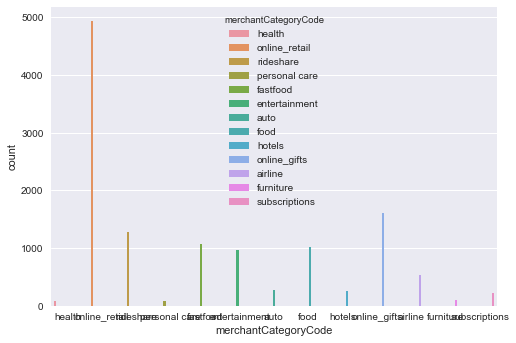

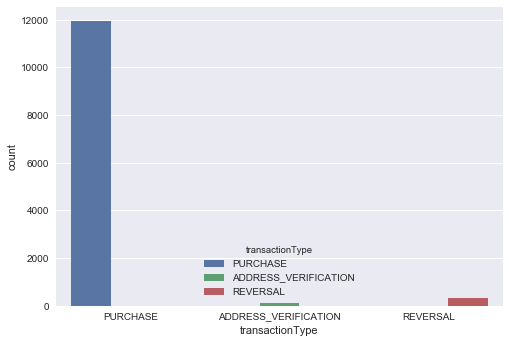

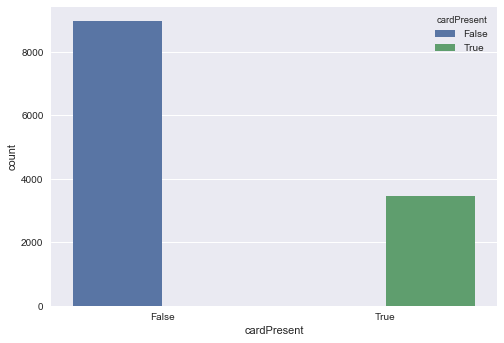

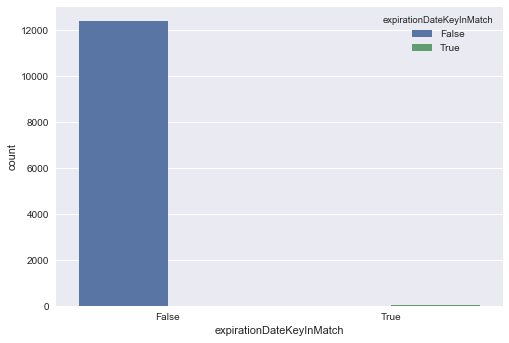

In [7]:
## understand in fraud transaction, the distribution of categorical features 
for col in col_list:
    sns.countplot( x = col, data = df_1[df_1['isFraud']== True],hue = col)
    plt.show()

#### Summary : In Fraud transaction,  categorical features analysis 
1.creditLimit : 5000 ,15000,7500 are top 3 distribution 
<br>
2.merchantCategoryCode : online_retail online_gifts rideshare
<br>
3.transactionType: 96% are  PURCHASE transaction 
<br>
4.cardPresent: 2/3 are no present 
<br>
5.expirationDateKeyInMatch : 98% are not match 

After very basic Exploratory Data Analysis, we have to do some data cleaning and data preprocessing. 
First, we need to encode the categorical feature. 
Second, we need to impute the missing value for both numeric and categorical feature. 
Third, we need to scale out feature, which can be better for our models' performance.

## Part 2 : Feature Preprocessing 

### 2.1 Train test split 

#### Drop some unwanted columns

In [101]:
# df_1 = df_1.drop(['accountOpenDate','currentExpDate','dateOfLastAddressChange', 'transactionDateTime'],axis =1 )  

# df_1.to_pickle('data/df_1') 

In [404]:
df_1 = pd.read_pickle('data/df_1')

In [405]:
df_1.isnull().sum()

creditLimit                         0
transactionAmount                   0
merchantName                        0
acqCountry                       4562
posEntryMode                     4054
posConditionCode                  409
merchantCategoryCode                0
transactionType                   698
currentBalance                      0
cardPresent                         0
expirationDateKeyInMatch            0
isFraud                             0
transactionAmount_log               0
availableMoney_log                  0
currentBalance_log                  0
balance_limit_ratio_log             0
transaction_balance_ratio_log       0
CVV_correct                         0
domesticTransaction                 0
dtype: int64

In [406]:
y = df_1['isFraud']
X = df_1

# default to stratified sampling
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size =0.25, random_state = 0)

print('the shape of X_train :', X_train.shape, 'The shape of X_test', X_test.shape)

the shape of X_train : (589772, 19) The shape of X_test (196591, 19)


### 2.2 Encoding Categorical features

In [407]:
cat_cols = df_1.columns[(df_1.dtypes == 'object') | (df_1.dtypes == 'string')]
print(cat_cols)

Index(['merchantName', 'acqCountry', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType'],
      dtype='object')


In [408]:
df_1[cat_cols].nunique()

merchantName            205
acqCountry                4
posEntryMode              5
posConditionCode          3
merchantCategoryCode     19
transactionType           3
dtype: int64

#### Decide the encoding method for categorical features

merchantName ------------           ratio-encoding + hashing
<br>
acqCountry ------------             ratio-encoding + one-hot-encoding
<br>
posEntryMode ------------           ratio-encoding + one-hot-encoding
<br>
posConditionCode ------------       ratio-encoding+ one-hot-encoding
<br>
merchantCategoryCode ------------   ratio-encoding + binary-encoding
<br>
transactionType ------------        ratio-encoding+ one-hot-encoding
<br>
creditLimit   ------------      ratio-encoding + binary-encoding

### Ratio-encoding features

In [409]:
def ratio_encoding(tr_df, test_df, agg_col, new_col):
    map_series = 100 - tr_df.groupby([agg_col, 'isFraud']).agg({'isFraud': 'count'})\
                        .rename(columns = {'isFraud': 'isFraudValue'})\
                        .groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))\
                        .query('isFraud == False').reset_index().set_index(agg_col)['isFraudValue']

    tr_df[new_col] = tr_df[agg_col].map(map_series)
    test_df[new_col] = test_df[agg_col].map(map_series)
    
    return tr_df, test_df

### Binary-encoding features

In [410]:
def binary_encoding(tr_df, test_df, col):
    encoder = ce.BinaryEncoder(cols=[col])
    tr_encoded = encoder.fit_transform(tr_df[col])
    test_encoded = encoder.transform(test_df[col])
    
    tr_encoded.index = tr_df.index
    test_encoded.index = test_df.index
    
    tr_df = pd.concat([tr_df, tr_encoded], axis=1)
    test_df = pd.concat([test_df, test_encoded], axis=1)

    return tr_df, test_df

### Hashing features

In [411]:
def hashing(tr_df, test_df, col, n_components):
    encoder = ce.HashingEncoder(cols=[col], n_components=n_components)
    tr_encoded = encoder.fit_transform(tr_df[col])
    test_encoded = encoder.transform(test_df[col])
    
    columns = dict(zip(['col_{}'.format(i) for i in range(n_components)], 
                    ['{}_{}'.format(col, i) for i in range(n_components)]))
    
    tr_encoded.index = tr_df.index
    test_encoded.index = test_df.index
    
    tr_df = pd.concat([tr_df, tr_encoded], axis=1).rename(columns = columns)
    test_df = pd.concat([test_df, test_encoded], axis=1).rename(columns = columns)

    return tr_df, test_df

### One-Hot-Encoding features

In [412]:
def ohe(tr_df, test_df, col):
    encoder = ce.OneHotEncoder(cols=[col], handle_unknown='return_nan', use_cat_names=True)
    tr_encoded = encoder.fit_transform(tr_df[col])
    test_encoded = encoder.transform(test_df[col])
    
    tr_encoded.index = tr_df.index
    test_encoded.index = test_df.index
    
    tr_df = pd.concat([tr_df, tr_encoded], axis=1)
    test_df = pd.concat([test_df, test_encoded], axis=1)
    
    return tr_df, test_df

#### merchantName

ratio-encoding + hashing merchantName

In [413]:
X_train, X_test = ratio_encoding(X_train, X_test, 'merchantName', 'merchantName_ratio')
X_train, X_test = hashing(X_train, X_test, 'merchantName', 10)

X_train.head()

/Users/nora/miniconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9
170115,2500,13.710,1st Sandwitch Bar,US,09,01,food,PURCHASE,655.660,True,False,False,2.689,7.955,6.487,0.233,0.307,True,True,1.159,0,0,0,0,0,0,0,0,0,1
660226,5000,123.540,AMC,US,02,01,entertainment,PURCHASE,3069.630,False,False,False,4.825,7.985,8.030,0.479,0.428,True,True,0.690,0,0,0,0,0,0,0,1,0,0
208078,15000,116.590,Franks Restaurant,US,05,01,food,PURCHASE,7644.670,True,False,False,4.767,9.031,8.942,0.412,0.392,True,True,2.345,0,0,0,0,0,0,1,0,0,0
341822,15000,80.810,walmart.com,US,02,01,online_retail,PURCHASE,10980.230,False,False,False,4.404,8.522,9.304,0.549,0.356,True,True,2.664,0,0,0,0,0,0,1,0,0,0
632238,15000,40.030,amazon.com,US,02,01,online_retail,PURCHASE,3932.350,False,False,False,3.714,9.399,8.277,0.233,0.337,True,True,2.240,1,0,0,0,0,0,0,0,0,0


#### acqCountry
atio-encoding + one-hot-encoding acqCountry

In [414]:
X_train, X_test = ratio_encoding(X_train, X_test, 'acqCountry', 'acqCountry_ratio')
X_train, X_test = ohe(X_train, X_test, 'acqCountry')

X_train.head()

/Users/nora/miniconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_nan,acqCountry_MEX,acqCountry_CAN,acqCountry_PR
170115,2500,13.710,1st Sandwitch Bar,US,09,01,food,PURCHASE,655.660,True,False,False,2.689,7.955,6.487,0.233,0.307,True,True,1.159,0,0,0,0,0,0,0,0,0,1,1.584,1.000,0.000,0.000,0.000,0.000
660226,5000,123.540,AMC,US,02,01,entertainment,PURCHASE,3069.630,False,False,False,4.825,7.985,8.030,0.479,0.428,True,True,0.690,0,0,0,0,0,0,0,1,0,0,1.584,1.000,0.000,0.000,0.000,0.000
208078,15000,116.590,Franks Restaurant,US,05,01,food,PURCHASE,7644.670,True,False,False,4.767,9.031,8.942,0.412,0.392,True,True,2.345,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000
341822,15000,80.810,walmart.com,US,02,01,online_retail,PURCHASE,10980.230,False,False,False,4.404,8.522,9.304,0.549,0.356,True,True,2.664,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000
632238,15000,40.030,amazon.com,US,02,01,online_retail,PURCHASE,3932.350,False,False,False,3.714,9.399,8.277,0.233,0.337,True,True,2.240,1,0,0,0,0,0,0,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000


#### posEntryMode 
ratio-encoding + one-hot-encoding posEntryMode

In [415]:
X_train, X_test = ratio_encoding(X_train, X_test, 'posEntryMode', 'posEntryMode_ratio')
X_train, X_test = ohe(X_train, X_test, 'posEntryMode')

X_train.head()

/Users/nora/miniconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_nan,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan
170115,2500,13.710,1st Sandwitch Bar,US,09,01,food,PURCHASE,655.660,True,False,False,2.689,7.955,6.487,0.233,0.307,True,True,1.159,0,0,0,0,0,0,0,0,0,1,1.584,1.000,0.000,0.000,0.000,0.000,2.411,1.000,0.000,0.000,0.000,0.000,0.000
660226,5000,123.540,AMC,US,02,01,entertainment,PURCHASE,3069.630,False,False,False,4.825,7.985,8.030,0.479,0.428,True,True,0.690,0,0,0,0,0,0,0,1,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000
208078,15000,116.590,Franks Restaurant,US,05,01,food,PURCHASE,7644.670,True,False,False,4.767,9.031,8.942,0.412,0.392,True,True,2.345,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,0.797,0.000,0.000,1.000,0.000,0.000,0.000
341822,15000,80.810,walmart.com,US,02,01,online_retail,PURCHASE,10980.230,False,False,False,4.404,8.522,9.304,0.549,0.356,True,True,2.664,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000
632238,15000,40.030,amazon.com,US,02,01,online_retail,PURCHASE,3932.350,False,False,False,3.714,9.399,8.277,0.233,0.337,True,True,2.240,1,0,0,0,0,0,0,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000


#### posConditionCode
ratio-encoding + one-hot-encoding posConditionCode

In [416]:
X_train, X_test = ratio_encoding(X_train, X_test, 'posConditionCode', 'posConditionCode_ratio')
X_train, X_test = ohe(X_train, X_test, 'posConditionCode')

X_train.head()

/Users/nora/miniconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_nan,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_nan
170115,2500,13.710,1st Sandwitch Bar,US,09,01,food,PURCHASE,655.660,True,False,False,2.689,7.955,6.487,0.233,0.307,True,True,1.159,0,0,0,0,0,0,0,0,0,1,1.584,1.000,0.000,0.000,0.000,0.000,2.411,1.000,0.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000
660226,5000,123.540,AMC,US,02,01,entertainment,PURCHASE,3069.630,False,False,False,4.825,7.985,8.030,0.479,0.428,True,True,0.690,0,0,0,0,0,0,0,1,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000
208078,15000,116.590,Franks Restaurant,US,05,01,food,PURCHASE,7644.670,True,False,False,4.767,9.031,8.942,0.412,0.392,True,True,2.345,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,0.797,0.000,0.000,1.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000
341822,15000,80.810,walmart.com,US,02,01,online_retail,PURCHASE,10980.230,False,False,False,4.404,8.522,9.304,0.549,0.356,True,True,2.664,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000
632238,15000,40.030,amazon.com,US,02,01,online_retail,PURCHASE,3932.350,False,False,False,3.714,9.399,8.277,0.233,0.337,True,True,2.240,1,0,0,0,0,0,0,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000


#### merchantCategoryCode

ratio encoding + binary-encoding merchantCategoryCode

In [417]:
X_train, X_test = ratio_encoding(X_train, X_test, 'merchantCategoryCode', 'merchantCategoryCode_ratio')
X_train, X_test = binary_encoding(X_train, X_test, 'merchantCategoryCode')

X_train.head()

/Users/nora/miniconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_nan,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5
170115,2500,13.710,1st Sandwitch Bar,US,09,01,food,PURCHASE,655.660,True,False,False,2.689,7.955,6.487,0.233,0.307,True,True,1.159,0,0,0,0,0,0,0,0,0,1,1.584,1.000,0.000,0.000,0.000,0.000,2.411,1.000,0.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,1.395,0,0,0,0,0,1
660226,5000,123.540,AMC,US,02,01,entertainment,PURCHASE,3069.630,False,False,False,4.825,7.985,8.030,0.479,0.428,True,True,0.690,0,0,0,0,0,0,0,1,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,1.214,0,0,0,0,1,0
208078,15000,116.590,Franks Restaurant,US,05,01,food,PURCHASE,7644.670,True,False,False,4.767,9.031,8.942,0.412,0.392,True,True,2.345,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,0.797,0.000,0.000,1.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,1.395,0,0,0,0,0,1
341822,15000,80.810,walmart.com,US,02,01,online_retail,PURCHASE,10980.230,False,False,False,4.404,8.522,9.304,0.549,0.356,True,True,2.664,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,2.467,0,0,0,0,1,1
632238,15000,40.030,amazon.com,US,02,01,online_retail,PURCHASE,3932.350,False,False,False,3.714,9.399,8.277,0.233,0.337,True,True,2.240,1,0,0,0,0,0,0,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,2.467,0,0,0,0,1,1


#### transactionType
ratio-encoding+ one-hot-encoding transactionType

In [418]:
X_train, X_test = ratio_encoding(X_train, X_test, 'transactionType', 'transactionType_ratio')
X_train, X_test = ohe(X_train, X_test, 'transactionType')

X_train.head()

/Users/nora/miniconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_nan,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_ADDRESS_VERIFICATION,transactionType_REVERSAL,transactionType_nan
170115,2500,13.710,1st Sandwitch Bar,US,09,01,food,PURCHASE,655.660,True,False,False,2.689,7.955,6.487,0.233,0.307,True,True,1.159,0,0,0,0,0,0,0,0,0,1,1.584,1.000,0.000,0.000,0.000,0.000,2.411,1.000,0.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,1.395,0,0,0,0,0,1,1.622,1.000,0.000,0.000,0.000
660226,5000,123.540,AMC,US,02,01,entertainment,PURCHASE,3069.630,False,False,False,4.825,7.985,8.030,0.479,0.428,True,True,0.690,0,0,0,0,0,0,0,1,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,1.214,0,0,0,0,1,0,1.622,1.000,0.000,0.000,0.000
208078,15000,116.590,Franks Restaurant,US,05,01,food,PURCHASE,7644.670,True,False,False,4.767,9.031,8.942,0.412,0.392,True,True,2.345,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,0.797,0.000,0.000,1.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,1.395,0,0,0,0,0,1,1.622,1.000,0.000,0.000,0.000
341822,15000,80.810,walmart.com,US,02,01,online_retail,PURCHASE,10980.230,False,False,False,4.404,8.522,9.304,0.549,0.356,True,True,2.664,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,2.467,0,0,0,0,1,1,1.622,1.000,0.000,0.000,0.000
632238,15000,40.030,amazon.com,US,02,01,online_retail,PURCHASE,3932.350,False,False,False,3.714,9.399,8.277,0.233,0.337,True,True,2.240,1,0,0,0,0,0,0,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,2.467,0,0,0,0,1,1,1.622,1.000,0.000,0.000,0.000


#### creditLimit
ratio-encoding + binary-encoding creditLimit

In [419]:
X_train, X_test = ratio_encoding(X_train, X_test, 'creditLimit', 'creditLimit_ratio')
X_train, X_test = binary_encoding(X_train, X_test, 'creditLimit')

X_train.head()

/Users/nora/miniconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,creditLimit,transactionAmount,merchantName,acqCountry,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_nan,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_ADDRESS_VERIFICATION,transactionType_REVERSAL,transactionType_nan,creditLimit_ratio,creditLimit_0,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4
170115,2500,13.710,1st Sandwitch Bar,US,09,01,food,PURCHASE,655.660,True,False,False,2.689,7.955,6.487,0.233,0.307,True,True,1.159,0,0,0,0,0,0,0,0,0,1,1.584,1.000,0.000,0.000,0.000,0.000,2.411,1.000,0.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,1.395,0,0,0,0,0,1,1.622,1.000,0.000,0.000,0.000,1.537,0,0,0,0,1
660226,5000,123.540,AMC,US,02,01,entertainment,PURCHASE,3069.630,False,False,False,4.825,7.985,8.030,0.479,0.428,True,True,0.690,0,0,0,0,0,0,0,1,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,1.214,0,0,0,0,1,0,1.622,1.000,0.000,0.000,0.000,1.736,0,0,0,1,0
208078,15000,116.590,Franks Restaurant,US,05,01,food,PURCHASE,7644.670,True,False,False,4.767,9.031,8.942,0.412,0.392,True,True,2.345,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,0.797,0.000,0.000,1.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,1.395,0,0,0,0,0,1,1.622,1.000,0.000,0.000,0.000,1.860,0,0,0,1,1
341822,15000,80.810,walmart.com,US,02,01,online_retail,PURCHASE,10980.230,False,False,False,4.404,8.522,9.304,0.549,0.356,True,True,2.664,0,0,0,0,0,0,1,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,2.467,0,0,0,0,1,1,1.622,1.000,0.000,0.000,0.000,1.860,0,0,0,1,1
632238,15000,40.030,amazon.com,US,02,01,online_retail,PURCHASE,3932.350,False,False,False,3.714,9.399,8.277,0.233,0.337,True,True,2.240,1,0,0,0,0,0,0,0,0,0,1.584,1.000,0.000,0.000,0.000,0.000,1.771,0.000,1.000,0.000,0.000,0.000,0.000,1.645,1.000,0.000,0.000,0.000,2.467,0,0,0,0,1,1,1.622,1.000,0.000,0.000,0.000,1.860,0,0,0,1,1


### 2.3 Binning + ratio-encoding Numerical features 

### Binning numerical features

In [420]:
def bin_column(tr_df, test_df, col_name, new_col_name, bin_num, minv, maxv):
    if new_col_name in tr_df.columns:
        tr_df.drop([new_col_name],axis = 1, inplace=True)
    if new_col_name in test_df.columns:
        test_df.drop([new_col_name],axis = 1, inplace=True)

    bins = np.linspace(minv, maxv, bin_num+1)
    bins = np.insert(bins, 0, float("-inf"), axis=0)
    bins = np.insert(bins, len(bins), float("inf"), axis=0)
    # bins = [-inf, minv, ..., maxv, inf]
    ss, bins = pd.cut(tr_df[col_name], bins=bins, retbins=True, labels=False) 
    ss.name = new_col_name
    tr_df = tr_df.join(ss)

    test_ss = pd.cut(test_df[col_name], bins=bins, labels=False, include_lowest=True)
    test_ss.name = new_col_name
    test_df = test_df.join(test_ss)
  
    return tr_df, test_df

####  binning transactionAmount & binning_ratio

In [421]:
X_train['transactionAmount_log'].min(), X_train['transactionAmount_log'].max()

(0.0, 7.607152884871596)

In [422]:
bin_num = 8

X_train, X_test = bin_column(X_train, X_test, 'transactionAmount_log', 'bin_transactionAmount', bin_num, 0, 7)

X_train, X_test = ratio_encoding(X_train, X_test, 'bin_transactionAmount', 'transactionAmount_ratio')

X_train.transactionAmount_ratio.value_counts()

1.693    165709
1.023    132939
2.755    123645
0.658     67928
0.458     37785
4.113     24922
0.570     16681
0.495     14937
0.290      4834
5.867       392
Name: transactionAmount_ratio, dtype: int64

#### binning currentBalance & binning_ratio

In [423]:
X_train['currentBalance_log'].min(), X_train['currentBalance_log'].max()

(0.0, 10.768439515304562)

In [424]:
bin_num = 11

X_train, X_test = bin_column(X_train, X_test, 'currentBalance_log', 'bin_currentBalance', bin_num, 0, 10)

X_train, X_test = ratio_encoding(X_train, X_test, 'bin_currentBalance', 'currentBalance_ratio')

X_train.currentBalance_ratio.value_counts()

1.624    145907
1.639    142620
1.569     80440
1.747     71418
1.578     51382
1.310     33588
1.307     25329
1.383     14754
2.030     14677
1.240      5725
1.379      2610
1.041      1057
0.755       265
Name: currentBalance_ratio, dtype: int64

#### binning balance_limit_ratio_log & binning_ratio

In [425]:
X_train['balance_limit_ratio_log'].min(), X_train['balance_limit_ratio_log'].max()

(0.0, 1.7295506766087299)

In [426]:
bin_num = 5

X_train, X_test = bin_column(X_train, X_test, 'balance_limit_ratio_log', 'bin_balance_limit_ratio', bin_num, 0, 1.7)

X_train, X_test = ratio_encoding(X_train, X_test, 'bin_balance_limit_ratio', 'balance_limit_ratio_ratio')

X_train.balance_limit_ratio_ratio.value_counts()

1.679    327032
1.517    234991
1.307     25329
1.345      2082
1.656       302
5.714        35
0.000         1
Name: balance_limit_ratio_ratio, dtype: int64

#### binning transaction_balance_ratio_log & binning_ratio

In [427]:
X_train['transaction_balance_ratio_log'].min(), X_train['transaction_balance_ratio_log'].max()

(0.0, 2.1050236061450196)

In [428]:
bin_num = 6

X_train, X_test = bin_column(X_train, X_test, 'transaction_balance_ratio_log', 'bin_transaction_balance_ratio', bin_num, 0, 2)

X_train, X_test = ratio_encoding(X_train, X_test, 'bin_transaction_balance_ratio', 'transaction_balance_ratio_ratio')

X_train.transaction_balance_ratio_ratio.value_counts()

1.891    413683
0.676    119683
0.570     16681
2.253     15091
2.003     11882
0.856      8294
0.712      4075
4.178       383
Name: transaction_balance_ratio_ratio, dtype: int64

### 2.4 Ratio-encoding binary features

#### CVV_correct_ratio

In [429]:
X_train, X_test = ratio_encoding(X_train, X_test, 'CVV_correct', 'CVV_correct_ratio')

X_train.CVV_correct_ratio.value_counts()

1.585    584542
2.983      5230
Name: CVV_correct_ratio, dtype: int64

#### domesticTransaction

In [430]:
X_train, X_test = ratio_encoding(X_train, X_test, 'domesticTransaction', 'domesticTransaction_ratio')

X_train.domesticTransaction_ratio.value_counts()

1.590    586265
2.908      3507
Name: domesticTransaction_ratio, dtype: int64

### 2.5 Standardise features

#### drop categorical features which contain string etc.

In [431]:
X_train.columns[(X_train.dtypes == 'object')]

Index(['merchantName', 'acqCountry', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType'],
      dtype='object')

In [432]:
X_train = X_train.drop(['merchantName', 'acqCountry', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType'], axis=1)
X_test = X_test.drop(['merchantName', 'acqCountry', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'transactionType'], axis=1)

In [433]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589772 entries, 170115 to 305711
Data columns (total 70 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   creditLimit                           589772 non-null  int64  
 1   transactionAmount                     589772 non-null  float64
 2   currentBalance                        589772 non-null  float64
 3   cardPresent                           589772 non-null  bool   
 4   expirationDateKeyInMatch              589772 non-null  bool   
 5   isFraud                               589772 non-null  bool   
 6   transactionAmount_log                 589772 non-null  float64
 7   availableMoney_log                    589772 non-null  float64
 8   currentBalance_log                    589772 non-null  float64
 9   balance_limit_ratio_log               589772 non-null  float64
 10  transaction_balance_ratio_log         589772 non-null  float64


In [434]:
num_cols = X_train.columns[(X_train.dtypes == 'float64') | (X_train.dtypes == 'int64')]
print(num_cols)

Index(['creditLimit', 'transactionAmount', 'currentBalance',
       'transactionAmount_log', 'availableMoney_log', 'currentBalance_log',
       'balance_limit_ratio_log', 'transaction_balance_ratio_log',
       'merchantName_ratio', 'merchantName_0', 'merchantName_1',
       'merchantName_2', 'merchantName_3', 'merchantName_4', 'merchantName_5',
       'merchantName_6', 'merchantName_7', 'merchantName_8', 'merchantName_9',
       'acqCountry_ratio', 'acqCountry_US', 'acqCountry_nan', 'acqCountry_MEX',
       'acqCountry_CAN', 'acqCountry_PR', 'posEntryMode_ratio',
       'posEntryMode_09', 'posEntryMode_02', 'posEntryMode_05',
       'posEntryMode_80', 'posEntryMode_90', 'posEntryMode_nan',
       'posConditionCode_ratio', 'posConditionCode_01', 'posConditionCode_08',
       'posConditionCode_99', 'posConditionCode_nan',
       'merchantCategoryCode_ratio', 'merchantCategoryCode_0',
       'merchantCategoryCode_1', 'merchantCategoryCode_2',
       'merchantCategoryCode_3', 'merchantCat

#### standardise only numeric features, keep bool aside

In [435]:
scaler = preprocessing.StandardScaler()

# 转化后的数据是 numpy 数组
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [436]:
X_train.describe()

,creditLimit,transactionAmount,currentBalance,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_nan,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_ADDRESS_VERIFICATION,transactionType_REVERSAL,transactionType_nan,creditLimit_ratio,creditLimit_0,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4,bin_transactionAmount,transactionAmount_ratio,bin_currentBalance,currentBalance_ratio,bin_balance_limit_ratio,balance_limit_ratio_ratio,bin_transaction_balance_ratio,transaction_balance_ratio_ratio,CVV_correct_ratio,domesticTransaction_ratio
count,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,586318.000,589772.000,589772.000,589772.000,589772.000,589772.000,586696.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589482.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589265.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000,589772.000
mean,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.903,-0.927,-0.698,-2.999,-10.032,-3.375,-1.642,-1.602,-1.310,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,-0.086,-8.151,-0.077,-0.063,-0.055,-0.044,-1.133,-0.656,-0.576,-0.818,-0.141,-0.160,-0.072,-1.450,-2.000,-0.484,-0.098,-0.022,-1.826,0.000,-0.264,-0.459,-0.812,-1.407,-1.125,-6.157,-4.257,-0.162,-0.163,-0.029,-1.685,0.000,-0.403,-0.703,-1.408,-0.877,-3.169,-1.381,-3.442,-5.968,-2.583,-15.143,-2.098,-1.894,-0.095,-0.077
25%,-0.495,-0.699,-0.591,-0.494,-0.821,-0.345,-0.907,-0.399,-0.744,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,-0.086,0.123,-0.077,-0.063,-0.055,-0.044,-1.133,-0.656,-0.576,-0.818,-0.141,-0.160,-0.072,0.254,0.500,-0.484,-0.098,-0.022,-0.735,0.000,-0.264,-0.459,-0.812,-1.407,-1.125,0.157,0.235,-0.162,-0.163,-0.029,-1.155,0.000,-0.403,-0.703,-1.408,-0.877,-0.200,-0.607,-0.204,-0.203,-0.884,-0.763,0.104,-1.366,-0.095,-0.077
50%,-0.280,-0.332,-0.319,0.172,-0.075,0.242,0.145,-0.124,-0.089,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,-0.086,0.123,-0.077,-0.063,-0.055,-0.044,0.292,-0.656,-0.576,-0.818,-0.141,-0.160,-0.072,0.254,0.500,-0.484,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.

In [437]:
X_train.isnull().sum()

creditLimit                                0
transactionAmount                          0
currentBalance                             0
cardPresent                                0
expirationDateKeyInMatch                   0
isFraud                                    0
transactionAmount_log                      0
availableMoney_log                         0
currentBalance_log                         0
balance_limit_ratio_log                    0
transaction_balance_ratio_log              0
CVV_correct                                0
domesticTransaction                        0
merchantName_ratio                         0
merchantName_0                             0
merchantName_1                             0
merchantName_2                             0
merchantName_3                             0
merchantName_4                             0
merchantName_5                             0
merchantName_6                             0
merchantName_7                             0
merchantNa

In [438]:
X_train[X_train['acqCountry_ratio'].isnull().values].head()

,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_nan,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_ADDRESS_VERIFICATION,transactionType_REVERSAL,transactionType_nan,creditLimit_ratio,creditLimit_0,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4,bin_transactionAmount,transactionAmount_ratio,bin_currentBalance,currentBalance_ratio,bin_balance_limit_ratio,balance_limit_ratio_ratio,bin_transaction_balance_ratio,transaction_balance_ratio_ratio,CVV_correct_ratio,domesticTransaction_ratio
575274,-0.495,-0.619,-0.139,False,False,False,-0.287,-0.672,0.422,0.868,-0.372,True,False,0.642,-0.402,-0.255,-0.306,2.236,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,NaN,-8.151,13.029,-0.063,-0.055,-0.044,1.228,1.525,-0.576,-0.818,-0.141,-0.160,-0.072,-1.450,-2.000,2.065,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.162,-0.163,-0.029,0.669,0.000,-0.403,-0.703,0.710,-0.877,-0.200,-0.607,0.605,0.189,0.815,0.772,0.104,0.541,-0.095,12.929
665497,-0.838,0.020,-0.570,True,False,False,0.497,-1.428,-0.261,1.141,0.144,True,False,-0.936,-0.402,-0.255,-0.306,2.236,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,NaN,-8.151,13.029,-0.063,-0.055,-0.044,1.228,1.525,-0.576,-0.818,-0.141,-0.160,-0.072,0.254,0.500,-0.484,-0.098,-0.022,-1.003,0.000,-0.264,2.179,1.232,-1.407,0.889,0.157,0.235,-0.162,-0.163,-0.029,-0.450,0.000,-0.403,1.423,-1.408,1.140,0.394,0.100,-0.204,-0.203,0.815,0.772,0.104,0.541,-0.095,12.929
516657,-0.280,0.310,-0.586,True,False,False,0.684,0.584,-0.321,-1.216,0.241,True,False,-0.051,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,3.817,NaN,-8.151,13.029,-0.063,-0.055,-0.044,1.228,1.525,-0.576,-0.818,-0.141,-0.160,-0.072,0.254,0.500,-0.484,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.162,-0.163,-0.029,-1.155,0.000,-0.403,1.423,0.710,-0.877,0.394,0.100,-0.204,-0.203,-0.884,-0.763,0.104,0.541,-0.095,12.929
515871,-0.838,-0.646,-0.611,True,False,False,-0.351,-1.213,-0.439,0.421,-0.148,True,False,-0.500,-0.402,-0.255,-0.306,-0.447,-0.315,3.771,-0.349,-0.390,-0.307,-0.262,NaN,-8.151,13.029,-0.063,-0.055,-0.044,1.228,1.525,-0.576,-0.818,-0.141,-0.160,-0.072,0.254,0.500,-0.484,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.162,-0.163,-0.029,-0.450,0.000,-0.403,1.423,-1.408,1.140,-0.200,-0.607,-0.609,-0.136,0.815,0.772,0.104,0.541,-0.095,12.929
480311,0.793,-0.838,1.856,True,False,False,-1.129,0.003,1.126,1.136,-0.824,True,False,0.787,-0.402,-0.255,-0.306,2.236,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,NaN,-8.151,13.029,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.818,-0.141,-0.160,-0.072,0.254,0.500,-0.484,-0.098,-0.022,-0.448,0.000,-0.264,2.179,1.232,0.711,-1.125,0.157,0.235,-0.162,-0.163,-0.029,-1.316,0.000,-0.403,1.423,-1.408,-0.877,-0.794,-0.992,1.010,1.061,0.815,0.772,-0.997,-1.698,-0.095,12.929


In [439]:
X_train['CVV_correct'] = np.where(X_train['CVV_correct'], 1, 0)
X_train['cardPresent'] = np.where(X_train['cardPresent'], 1, 0)
X_train['expirationDateKeyInMatch'] = np.where(X_train['expirationDateKeyInMatch'], 1, 0)
X_train['domesticTransaction'] = np.where(X_train['domesticTransaction'], 1, 0)
X_train['isFraud'] = np.where(X_train['isFraud'], 1, 0)

X_test['CVV_correct'] = np.where(X_test['CVV_correct'], 1, 0)
X_test['cardPresent'] = np.where(X_test['cardPresent'], 1, 0)
X_test['expirationDateKeyInMatch'] = np.where(X_test['expirationDateKeyInMatch'], 1, 0)
X_test['domesticTransaction'] = np.where(X_test['domesticTransaction'], 1, 0)
X_test['isFraud'] = np.where(X_test['isFraud'], 1, 0)

In [449]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [450]:
X_train.loc[[575274, 665497]]

,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_nan,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_ADDRESS_VERIFICATION,transactionType_REVERSAL,transactionType_nan,creditLimit_ratio,creditLimit_0,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4,bin_transactionAmount,transactionAmount_ratio,bin_currentBalance,currentBalance_ratio,bin_balance_limit_ratio,balance_limit_ratio_ratio,bin_transaction_balance_ratio,transaction_balance_ratio_ratio,CVV_correct_ratio,domesticTransaction_ratio
575274,-0.495,-0.619,-0.139,0,0,0,-0.287,-0.672,0.422,0.868,-0.372,1,0,0.642,-0.402,-0.255,-0.306,2.236,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,NaN,-8.151,13.029,-0.063,-0.055,-0.044,1.228,1.525,-0.576,-0.818,-0.141,-0.160,-0.072,-1.450,-2.000,2.065,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.162,-0.163,-0.029,0.669,0.000,-0.403,-0.703,0.710,-0.877,-0.200,-0.607,0.605,0.189,0.815,0.772,0.104,0.541,-0.095,12.929
665497,-0.838,0.020,-0.570,1,0,0,0.497,-1.428,-0.261,1.141,0.144,1,0,-0.936,-0.402,-0.255,-0.306,2.236,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,NaN,-8.151,13.029,-0.063,-0.055,-0.044,1.228,1.525,-0.576,-0.818,-0.141,-0.160,-0.072,0.254,0.500,-0.484,-0.098,-0.022,-1.003,0.000,-0.264,2.179,1.232,-1.407,0.889,0.157,0.235,-0.162,-0.163,-0.029,-0.450,0.000,-0.403,1.423,-1.408,1.140,0.394,0.100,-0.204,-0.203,0.815,0.772,0.104,0.541,-0.095,12.929


In [451]:
y_train[:5]

170115    0
660226    0
208078    0
341822    0
632238    0
Name: isFraud, dtype: int64

In [452]:
# X_train.to_pickle('data/X_train')
# y_train.to_pickle('data/y_train')
# X_test.to_pickle('data/X_test')
# y_test.to_pickle('data/y_test')

In [494]:
X_train = pd.read_pickle('data/X_train')
y_train = pd.read_pickle('data/y_train')
X_test = pd.read_pickle('data/X_test')
y_test = pd.read_pickle('data/y_test')

### 2.6 Missing value imputation : KNNImputer

A critical point here is that the KNN Imptuer is a distance-based imputation method and it requires us to normalize our data. Otherwise, the different scales of our data will lead the KNN Imputer to generate biased replacements for the missing values.

KNN Imputer maintains the value and variability of your datasets and yet it is more precise and efficient than using the average values.

In [454]:
from sklearn.impute import KNNImputer

KNN_imputer = KNNImputer(n_neighbors=3)
X_train_np = KNN_imputer.fit_transform(X_train)
X_test_np = KNN_imputer.transform(X_test)

In [497]:
X_train = pd.DataFrame(X_train_np, columns = X_train.columns, index = X_train.index)
X_train.isnull().sum()

creditLimit                             0
transactionAmount                       0
currentBalance                          0
cardPresent                             0
expirationDateKeyInMatch                0
isFraud                                 0
transactionAmount_log                   0
availableMoney_log                      0
currentBalance_log                      0
balance_limit_ratio_log                 0
transaction_balance_ratio_log           0
CVV_correct                             0
domesticTransaction                     0
merchantName_ratio                      0
merchantName_0                          0
merchantName_1                          0
merchantName_2                          0
merchantName_3                          0
merchantName_4                          0
merchantName_5                          0
merchantName_6                          0
merchantName_7                          0
merchantName_8                          0
merchantName_9                    

In [498]:
X_test = pd.DataFrame(X_test_np, columns = X_test.columns, index = X_test.index)
X_test.isnull().sum()

creditLimit                             0
transactionAmount                       0
currentBalance                          0
cardPresent                             0
expirationDateKeyInMatch                0
isFraud                                 0
transactionAmount_log                   0
availableMoney_log                      0
currentBalance_log                      0
balance_limit_ratio_log                 0
transaction_balance_ratio_log           0
CVV_correct                             0
domesticTransaction                     0
merchantName_ratio                      0
merchantName_0                          0
merchantName_1                          0
merchantName_2                          0
merchantName_3                          0
merchantName_4                          0
merchantName_5                          0
merchantName_6                          0
merchantName_7                          0
merchantName_8                          0
merchantName_9                    

In [499]:
# X_train.to_pickle('data/X_train_f')
# X_test.to_pickle('data/X_test_f')

### Remove highly correlated features

In [519]:
X_train_f = pd.read_pickle('data/X_train_f')
y_train = pd.read_pickle('data/y_train')
X_test_f = pd.read_pickle('data/X_test_f')
y_test = pd.read_pickle('data/y_test')

(589772, 70)


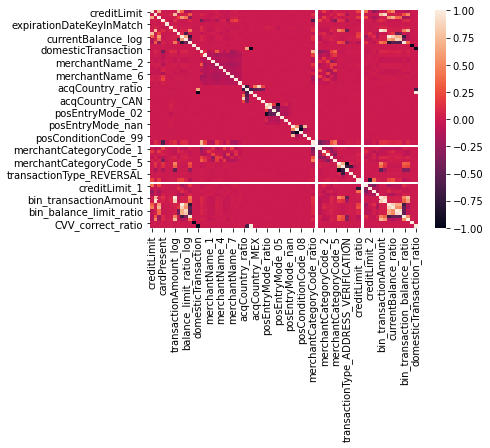

In [520]:
print(X_train_f.shape)

sns.heatmap(X_train_f.corr())
plt.show()

In [521]:
# Select upper triangle of correlation matrix
cor_matrix = X_train_f.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri

,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_nan,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_05,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_ADDRESS_VERIFICATION,transactionType_REVERSAL,transactionType_nan,creditLimit_ratio,creditLimit_0,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4,bin_transactionAmount,transactionAmount_ratio,bin_currentBalance,currentBalance_ratio,bin_balance_limit_ratio,balance_limit_ratio_ratio,bin_transaction_balance_ratio,transaction_balance_ratio_ratio,CVV_correct_ratio,domesticTransaction_ratio
creditLimit,NaN,0.006,0.654,0.005,0.001,0.004,0.006,0.759,0.340,0.127,0.127,0.000,0.002,0.022,0.009,0.001,0.010,0.019,0.027,0.012,0.027,0.017,0.035,0.012,0.000,0.001,0.002,0.001,0.001,0.001,0.002,0.000,0.003,0.002,0.000,0.001,0.001,0.001,0.000,0.001,0.000,0.007,0.032,NaN,0.002,0.163,0.004,0.069,0.052,0.000,0.001,0.000,0.002,0.001,0.216,NaN,0.405,0.020,0.281,0.174,0.006,0.006,0.324,0.466,0.079,0.053,0.106,0.115,0.000,0.002
transactionAmount,NaN,NaN,0.024,0.038,0.001,0.076,0.764,0.013,0.039,0.037,0.300,0.001,0.001,0.077,0.023,0.028,0.030,0.024,0.012,0.025,0.017,0.006,0.005,0.009,0.000,0.000,0.001,0.000,0.000,0.001,0.001,0.000,0.000,0.001,0.002,0.002,0.002,0.002,0.001,0.002,0.002,0.002,0.106,NaN,0.096,0.023,0.015,0.067,0.008,0.150,0.105,0.150,0.002,0.004,0.010,NaN,0.001,0.009,0.001,0.000,0.742,0.927,0.039,0.034,0.033,0.032,0.280,0.478,0.001,0.001
currentBalance,NaN,NaN,NaN,0.012,0.001,0.008,0.027,0.202,0.587,0.425,0.252,0.003,0.001,0.010,0.003,0.014,0.004,0.036,0.016,0.028,0.037,0.019,0.040,0.011,0.001,0.000,0.001,0.000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000,0.001,0.001,0.000,0.001,0.001,0.000,0.013,NaN,0.050,0.170,0.023,0.044,0.057,0.004,0.010,0.004,0.009,0.001,0.174,NaN,0.232,0.029,0.156,0.114,0.026,0.029,0.566,0.726,0.366,0.354,0.213,0.164,0.003,0.001
cardPresent,NaN,NaN,NaN,NaN,0.040,0.043,0.116,0.007,0.014,0.011,0.067,0.003,0.001,0.421,0.081,0.070,0.023,0.137,0.022,0.068,0.143,0.157,0.219,0.038,0.003,0.002,0.001,0.003,0.002,0.002,0.000,0.001,0.001,0.000,0.000,0.002,0.001,0.000,0.002,0.001,0.002,0.001,0.587,NaN,0.192,0.005,0.061,0.135,0.348,0.146,0.102,0.146,0.002,0.003,0.039,NaN,0.013,0.016,0.040,0.036,0.118,0.049,0.014,0.009,0.008,0.008,0.082,0.097,0.003,0.001
expirationDateKeyInMatch,NaN,NaN,NaN,NaN,NaN,0.001,0.004,0.001,0.002,0.000,0.002,0.001,0.004,0.015,0.004,0.003,0.003,0.005,0.004,0.002,0.005,0.006,0.007,0.002,0.001,0.001,0.004,0.001,0.000,0.002,0.001,0.001,0.002,0.000,0.000,0.002,0.000,0.004,0.002,0.003,0.003,0.001,0.022,NaN,0.002,0.004,0.003,0.005,0.013,0.006,0.007,0.006,0.004,0.001,0.001,NaN,0.005,0.002,0.004,0.001,0.004,0.001,0.002,0.001,0.000,0.000,0.003,0.005,0.001,0.004
isFraud,NaN,NaN,NaN,NaN,NaN,NaN,0.067,0.001,0.010,0.008,0.023,0.010,0.008,0.097,0.010,0.008,0.001,0.029,0.000,0.008,0.001,0.020,0.012,0.002,0.005,0.009,0.008,0.002,0.005,0.001,0.053,0.043,0.008,0.052,0.000,0.004,0.029,0.015,0.008,0.011,0.011,0.004,0.070,NaN,0.030,0.018,0.011,0.019,0.032,0.013,0.008,0.013,0.001,0.002,0.016,NaN,0.000,0.013,0.006,0.001,0.065,0.076,0.010,0.011,0.008,0.008,0.023,0.043,0.010,0.008
transactionAmount_log,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016,0.049,0.045,0.430,0.000,0.001,0.089,0.028,0.054,0.032,0.030,

In [522]:
# Find features with correlation greater than 0.9
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
to_drop

['acqCountry_nan',
 'posEntryMode_05',
 'posConditionCode_08',
 'transactionType_ADDRESS_VERIFICATION',
 'bin_transactionAmount',
 'transactionAmount_ratio',
 'bin_currentBalance',
 'balance_limit_ratio_ratio',
 'bin_transaction_balance_ratio',
 'CVV_correct_ratio',
 'domesticTransaction_ratio']

In [523]:
# Drop features 
X_train_f.drop(to_drop, axis=1, inplace=True)
X_test_f.drop(to_drop, axis=1, inplace=True)
X_train_f.shape

(589772, 59)

In [524]:
X_train_f_wty = X_train_f.drop(['isFraud'], axis=1)
X_test_f_wty = X_test_f.drop(['isFraud'], axis=1)
X_train_f_wty.shape

(589772, 58)

### 2.7 Visualise data cluster 

In [527]:
from sklearn.cluster import KMeans
import scipy

class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships. 
     This transformer runs k-means on the input data and converts each data point
     into the ID of the closest cluster. If a target variable is present, it is
     scaled and included as input to k-means in order to derive clusters that
     obey the classification boundary as well as group similar points together. """

    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        
    def fit(self, X, y=None):
        """Runs K-means on the input data and finds centroids.
        """
        
        if y is None:
            # No target variable, just do plain K-means
            km_model = KMeans(n_clusters = self.k, 
                              n_init = 20, # Number of time of run with different centroid seeds
                              random_state = self.random_state) #random number for centroid initialization
            km_model.fit(X)
            
            self.km_model = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self
        
        # There is target information. Apply appropriate scaling and include 
        # it in the input data to k-means
        # y[:, np.newaxis] change shape from (:,) to (:,1)
        data_with_target = np.hstack((X, y[:, np.newaxis]*self.target_scale))
        
        # Build a pre-training K-means model on data and target
        km_model_pretrain = KMeans(n_clusters = self.k, 
                                   n_init = 20, 
                                   random_state = self.random_state)
        km_model_pretrain.fit(data_with_target)
        
        # Run K-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid recomputation.
        km_model = KMeans(n_clusters = self.k,
                          init = km_model_pretrain.cluster_centers_[:,:-1], # shape: (n_clusters, n_features)
                          n_init = 1, 
                          max_iter = 1) # Maximum number of iterations for a single run
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers = km_model.cluster_centers_
        return self
    
    def transform(self, X, y=None):
        """Outputs the closest cluster ID for each input data point.
        """
        clusters = self.km_model.predict(X)
        return clusters[:, np.newaxis]
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

#### training KMeans using dataset without target

In [528]:
kmf = KMeansFeaturizer(k=4, random_state=1, target_scale=1).fit(X_train_f_wty)

# Use the k-means featurizer to generate cluster features
train_cluster = kmf.transform(X_train_f_wty)
test_cluster = kmf.transform(X_test_f_wty)


In [531]:
pd.DataFrame(np.hstack((X_train_f, train_cluster)), \
             columns=X_train_f.columns.append(pd.Index(['cluster'])), index = X_train_f.index)\
            .groupby(['cluster', 'isFraud']).agg({'isFraud': 'count'})\
            .groupby(level=0).apply(lambda x: x/float(x.sum())).rename(columns={'isFraud': 'isFraudValue'})\
            .reset_index().query('isFraud == 1')[['cluster', 'isFraudValue']]

,cluster,isFraudValue
1,0.000,0.024
3,1.000,0.010
5,2.000,0.013
7,3.000,0.026


#### Insight:

10.is there any cluster in fraud and non-fraud transaction?

After k-means clustering, some clusters can give relatively higher probability in finding fraud transaction.

#### feature engineering cluster with target

In [477]:
# pd.DataFrame(np.hstack((X_train_f, train_cluster, np.expand_dims(y_train, axis=1))), \
#              columns=X_train_f.columns.append(pd.Index(['cluster', 'isFraud']))).head()

In [532]:
# Form new input features with cluster features
X_train_f = pd.DataFrame(np.hstack((X_train_f, train_cluster)), \
             columns = X_train_f.columns.append(pd.Index(['cluster'])), \
             index = X_train_f.index)

X_test_f = pd.DataFrame(np.hstack((X_test_f, test_cluster)), \
             columns = X_test_f.columns.append(pd.Index(['cluster'])), \
             index = X_test_f.index)

X_train_f.head()

,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_REVERSAL,transactionType_nan,creditLimit_ratio,creditLimit_0,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4,currentBalance_ratio,bin_balance_limit_ratio,transaction_balance_ratio_ratio,cluster
170115,-0.710,-0.834,-0.597,1.000,0.000,0.000,-1.099,-0.487,-0.368,-0.566,-0.521,1.000,1.000,-0.360,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,3.817,-0.086,0.123,-0.063,-0.055,-0.044,1.228,1.525,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.163,-0.029,-0.296,0.000,-0.403,-0.703,-1.408,1.140,-0.203,-0.884,-1.698,1.000
660226,-0.495,-0.091,-0.223,0.000,0.000,0.000,0.410,-0.455,0.347,0.569,-0.094,1.000,1.000,-0.744,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,2.562,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.439,0.000,-0.264,-0.459,-0.812,0.711,-1.125,0.157,0.235,-0.163,-0.029,0.669,0.000,-0.403,-0.703,0.710,-0.877,0.296,0.815,0.541,1.000
208078,0.363,-0.138,0.486,1.000,0.000,0.000,0.369,0.661,0.769,0.261,-0.222,1.000,1.000,0.613,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,2.863,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,-1.133,-0.656,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,0.189,0.815,0.541,0.000
341822,0.363,-0.380,1.002,0.000,0.000,0.000,0.113,0.118,0.937,0.896,-0.348,1.000,1.000,0.875,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,2.863,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,1.061,0.815,0.541,0.000
632238,0.363,-0.656,-0.089,0.000,0.000,0.000,-0.375,1.053,0.461,-0.567,-0.416,1.000,1.000,0.527,2.485,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,0.189,-0.884,0.541,0.000


In [535]:
X_train_f, X_test_f = ratio_encoding(X_train_f, X_test_f, 'cluster', 'cluster_ratio')
X_train_f, X_test_f = ohe(X_train_f, X_test_f, 'cluster')

X_train_f.head()

/Users/nora/miniconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_REVERSAL,transactionType_nan,creditLimit_ratio,creditLimit_0,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4,currentBalance_ratio,bin_balance_limit_ratio,transaction_balance_ratio_ratio,cluster,cluster_ratio,cluster_1.0,cluster_0.0,cluster_2.0,cluster_3.0
170115,-0.710,-0.834,-0.597,1.000,0.000,0.000,-1.099,-0.487,-0.368,-0.566,-0.521,1.000,1.000,-0.360,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,3.817,-0.086,0.123,-0.063,-0.055,-0.044,1.228,1.525,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.163,-0.029,-0.296,0.000,-0.403,-0.703,-1.408,1.140,-0.203,-0.884,-1.698,1.000,0.999,1.000,0.000,0.000,0.000
660226,-0.495,-0.091,-0.223,0.000,0.000,0.000,0.410,-0.455,0.347,0.569,-0.094,1.000,1.000,-0.744,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,2.562,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.439,0.000,-0.264,-0.459,-0.812,0.711,-1.125,0.157,0.235,-0.163,-0.029,0.669,0.000,-0.403,-0.703,0.710,-0.877,0.296,0.815,0.541,1.000,0.999,1.000,0.000,0.000,0.000
208078,0.363,-0.138,0.486,1.000,0.000,0.000,0.369,0.661,0.769,0.261,-0.222,1.000,1.000,0.613,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,2.863,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,-1.133,-0.656,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,0.189,0.815,0.541,0.000,2.434,0.000,1.000,0.000,0.000
341822,0.363,-0.380,1.002,0.000,0.000,0.000,0.113,0.118,0.937,0.896,-0.348,1.000,1.000,0.875,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,2.863,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,1.061,0.815,0.541,0.000,2.434,0.000,1.000,0.000,0.000
632238,0.363,-0.656,-0.089,0.000,0.000,0.000,-0.375,1.053,0.461,-0.567,-0.416,1.000,1.000,0.527,2.485,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,0.189,-0.884,0.541,0.000,2.434,0.000,1.000,0.000,0.000


In [537]:
X_train_f.drop(['cluster'], axis=1, inplace=True)
X_test_f.drop(['cluster'], axis=1, inplace=True)

X_train_f.head()

,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_REVERSAL,transactionType_nan,creditLimit_ratio,creditLimit_0,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4,currentBalance_ratio,bin_balance_limit_ratio,transaction_balance_ratio_ratio,cluster_ratio,cluster_1.0,cluster_0.0,cluster_2.0,cluster_3.0
170115,-0.710,-0.834,-0.597,1.000,0.000,0.000,-1.099,-0.487,-0.368,-0.566,-0.521,1.000,1.000,-0.360,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,3.817,-0.086,0.123,-0.063,-0.055,-0.044,1.228,1.525,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.163,-0.029,-0.296,0.000,-0.403,-0.703,-1.408,1.140,-0.203,-0.884,-1.698,0.999,1.000,0.000,0.000,0.000
660226,-0.495,-0.091,-0.223,0.000,0.000,0.000,0.410,-0.455,0.347,0.569,-0.094,1.000,1.000,-0.744,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,2.562,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.439,0.000,-0.264,-0.459,-0.812,0.711,-1.125,0.157,0.235,-0.163,-0.029,0.669,0.000,-0.403,-0.703,0.710,-0.877,0.296,0.815,0.541,0.999,1.000,0.000,0.000,0.000
208078,0.363,-0.138,0.486,1.000,0.000,0.000,0.369,0.661,0.769,0.261,-0.222,1.000,1.000,0.613,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,2.863,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,-1.133,-0.656,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,0.189,0.815,0.541,2.434,0.000,1.000,0.000,0.000
341822,0.363,-0.380,1.002,0.000,0.000,0.000,0.113,0.118,0.937,0.896,-0.348,1.000,1.000,0.875,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,2.863,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,1.061,0.815,0.541,2.434,0.000,1.000,0.000,0.000
632238,0.363,-0.656,-0.089,0.000,0.000,0.000,-0.375,1.053,0.461,-0.567,-0.416,1.000,1.000,0.527,2.485,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,0.189,-0.884,0.541,2.434,0.000,1.000,0.000,0.000


#### standardise new created features

In [538]:
new_cols = ['cluster_ratio', 'cluster_1.0', 'cluster_0.0', 'cluster_2.0', 'cluster_3.0']

In [539]:
n_scaler = preprocessing.StandardScaler()

# 转化后的数据是 numpy 数组
X_train_f[new_cols] = n_scaler.fit_transform(X_train_f[new_cols])
X_test_f[new_cols] = n_scaler.transform(X_test_f[new_cols])

X_train_f.head()

,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_REVERSAL,transactionType_nan,creditLimit_ratio,creditLimit_0,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4,currentBalance_ratio,bin_balance_limit_ratio,transaction_balance_ratio_ratio,cluster_ratio,cluster_1.0,cluster_0.0,cluster_2.0,cluster_3.0
170115,-0.710,-0.834,-0.597,1.000,0.000,0.000,-1.099,-0.487,-0.368,-0.566,-0.521,1.000,1.000,-0.360,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,3.817,-0.086,0.123,-0.063,-0.055,-0.044,1.228,1.525,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.163,-0.029,-0.296,0.000,-0.403,-0.703,-1.408,1.140,-0.203,-0.884,-1.698,-0.890,1.043,-0.787,-0.395,-0.055
660226,-0.495,-0.091,-0.223,0.000,0.000,0.000,0.410,-0.455,0.347,0.569,-0.094,1.000,1.000,-0.744,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,2.562,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.439,0.000,-0.264,-0.459,-0.812,0.711,-1.125,0.157,0.235,-0.163,-0.029,0.669,0.000,-0.403,-0.703,0.710,-0.877,0.296,0.815,0.541,-0.890,1.043,-0.787,-0.395,-0.055
208078,0.363,-0.138,0.486,1.000,0.000,0.000,0.369,0.661,0.769,0.261,-0.222,1.000,1.000,0.613,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,2.863,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,-1.133,-0.656,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,0.189,0.815,0.541,1.244,-0.959,1.270,-0.395,-0.055
341822,0.363,-0.380,1.002,0.000,0.000,0.000,0.113,0.118,0.937,0.896,-0.348,1.000,1.000,0.875,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,2.863,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,1.061,0.815,0.541,1.244,-0.959,1.270,-0.395,-0.055
632238,0.363,-0.656,-0.089,0.000,0.000,0.000,-0.375,1.053,0.461,-0.567,-0.416,1.000,1.000,0.527,2.485,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,0.189,-0.884,0.541,1.244,-0.959,1.270,-0.395,-0.055


In [588]:
# X_train_f.to_pickle('data/X_train_f_cluster')
# X_test_f.to_pickle('data/X_test_f_cluster')

In [2]:
# import pickle5 as pickle
# X_train_f_cluster = pickle.load(open('./data/X_train_f_cluster', "rb"))
# X_test_f_cluster = pickle.load(open('./data/X_test_f_cluster', "rb"))

X_train_f_cluster = pd.read_pickle('data/X_train_f_cluster')
X_test_f_cluster = pd.read_pickle('data/X_test_f_cluster')

### 2.8 Dimension Reduction

1. Reduce the number of predictors

Why:

Having a large number of dimensions in the feature space can mean that the points often represent a small and non-representative sample.

This can dramatically impact the performance of machine learning algorithms, which is generally referred to as the “curse of dimensionality.” Therefore, it is often desirable to reduce the number of input features.

2. Make sure these variables are independent of each other

Dimension reduction combines those highly correlated variables into a set of uncorrelated variables. This will address the problem of multicollinearity.

In [3]:
X_train_c_wty = X_train_f_cluster.drop(['isFraud'], axis=1)
X_test_c_wty = X_test_f_cluster.drop(['isFraud'], axis=1)

X_train_c_wty.shape

(589772, 63)

### 2.8.1 Linear methods

### PCA (unsupervised)
input should not contain NaN, infinity.

32 components preserve 90% of the variance


Text(0, 0.5, 'cumulative explained variance')

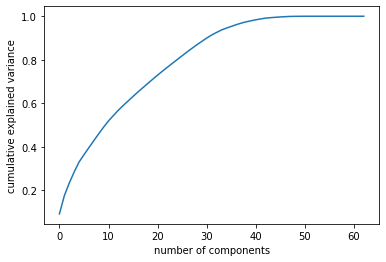

In [543]:
pca = PCA(0.90).fit(X_train_c_wty)
n_components = pca.n_components_
print('{} components preserve 90% of the variance'.format(n_components))


pca = PCA().fit(X_train_c_wty)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

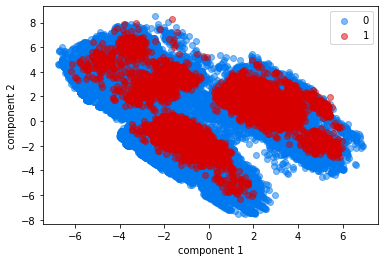

In [544]:
from sklearn.decomposition import PCA

pca = PCA(n_components = n_components)
projected = pca.fit_transform(X_train_c_wty)

cluster_colors = {0: '#0078ef', 1: '#d80000'}

for g in np.unique(y_train):
    idx = np.where(y_train == g)
    plt.scatter(projected[idx, 0], projected[idx, 1], 
            alpha=0.5, color=cluster_colors[g], label = g)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.legend()
plt.show()

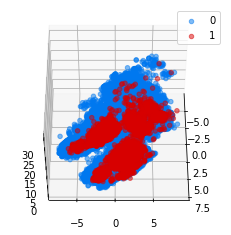

In [559]:
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

pca = PCA(n_components = n_components)
projected = pca.fit_transform(X_train_c_wty)

cluster_colors = {0: '#0078ef', 1: '#d80000'}

ax = plt.axes(projection='3d')

for g in np.unique(y_train):
    idx = np.where(y_train == g)
    ax.scatter3D(projected[idx, 0], projected[idx, 1], projected[idx, 2],
                alpha=0.5, color=cluster_colors[g], label = g)

ax.view_init(azim=0, elev=50)

plt.legend()
plt.show()

#### Insight:

The directions of highest variablility are not the direction of highest separation in 2 & 3 dimensions.

But it could potenially be seperable in high dimension, say, using SVM to build linear separable hyperplane, we can try later.

In [553]:
pca = PCA(n_components = n_components)

# transform return: (X_train - pca.mean_).dot(pca.components_.T)
X_train_pca = pca.fit_transform(X_train_c_wty)
X_test_pca = pca.transform(X_test_c_wty)

X_train_pca.shape, pca.components_.shape

((589772, 32), (32, 63))

In [556]:
X_train_pca = pd.DataFrame(X_train_pca, index = X_train_f.index)
X_test_pca = pd.DataFrame(X_test_pca, index = X_test_f.index)

X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
170115,-1.331,-0.414,-0.099,1.695,0.463,0.980,1.928,0.898,-0.133,0.355,-0.792,-0.074,-0.071,0.529,-0.315,-0.396,0.176,-0.207,0.573,0.644,3.997,0.635,-0.242,0.106,-0.187,0.001,0.115,0.708,-0.025,0.325,-0.709,-0.172
660226,-0.584,-1.566,-0.154,-1.151,1.314,-0.423,0.509,-1.116,0.324,-0.131,1.094,-1.793,-0.163,-0.837,-0.638,-0.587,-1.569,0.532,-0.875,-0.720,-0.606,0.744,0.081,-0.038,-0.025,0.017,0.135,-0.433,0.486,0.603,-0.252,1.000
208078,2.063,0.234,-0.212,-0.404,-0.442,-0.610,0.543,-1.856,0.404,-0.080,-0.325,1.558,0.047,-0.108,-1.120,-0.174,0.722,1.870,1.288,-0.545,0.512,-1.084,-0.022,0.080,-0.024,0.004,-0.065,0.141,-0.704,0.615,-0.410,-1.166
341822,3.371,0.139,-0.267,-0.417,-0.073,-0.970,0.430,-1.016,0.370,0.096,-0.495,0.569,-0.008,-0.446,-1.500,-0.363,-1.626,1.943,1.084,-0.479,0.406,-1.131,0.039,-0.094,-0.109,0.039,0.007,0.174,0.473,0.710,0.133,-0.489
632238,2.367,1.628,-0.261,0.557,-1.143,-0.903,0.795,-1.347,0.351,-0.935,0.079,-0.286,-0.042,1.167,-1.730,-0.313,-1.515,-0.680,-1.248,-0.384,0.423,-1.057,-0.078,-0.018,-0.156,-0.057,0.113,0.580,0.635,-0.531,0.188,-0.196


In [554]:
# transform return: X_train_pca.dot(pca.components_) + pca.mean_
# pca.inverse_transform obtains the projection onto components in signal space, 
# but the inversed data loss some information

X_projected = pca.inverse_transform(X_train_pca)
X_projected.shape

(589772, 63)

### LDA (supervised)

The labeled data (points) will be projected into a space with a lower dimension through projection, so that the projected points will be differentiated by category, cluster by cluster, and points of the same category will be Closer in the projected space.

Maximize the between-class variance while minimize the within-class variance.

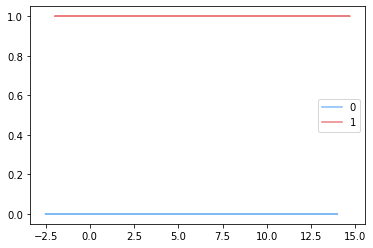

In [585]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
projected = lda.fit_transform(X_train_c_wty, y_train)

cluster_colors = {0: '#0078ef', 1: '#d80000'}

for g in np.unique(y_train):
    idx = np.where(y_train == g)
    plt.plot(projected[idx], len(projected[idx]) * [g], 
            alpha=0.5, color=cluster_colors[g], label = g)

plt.legend()
plt.show()

#### Insight:

The seperation between 0 and 1 has too much overlaps, which is not good.

### 2.8.2 Non-linear methods (Manifold learning)

Techniques from high-dimensionality statistics can also be used for dimensionality reduction, it is often for the purposes of data visualization..

The projection is designed to both create a low-dimensional representation of the dataset whilst best preserving the salient structure or relationships in the data.

### Kernal PCA (run out of memory)

The intuition behind Kernel PCA is that the data is first run through a kernel function and temporarily projects them into a new higher-dimensional feature space where the classes become linearly separable. Then the algorithm uses the normal PCA to project the data back onto a lower-dimensional space. 

In this way, Kernel PCA transform non-linear data into a lower-dimensional space of data which can be used with linear classifiers.

In [5]:
# from sklearn.decomposition import KernelPCA

# kpca = KernelPCA(n_components = 2, kernel='rbf', 
#                  gamma=15, random_state=42)
# projected = kpca.fit_transform(X_train_c_wty)

# cluster_colors = {0: '#0078ef', 1: '#d80000'}

# for g in np.unique(y_train):
#     idx = np.where(y_train == g)
#     plt.scatter(projected[idx, 0], projected[idx, 1], 
#             alpha=0.5, color=cluster_colors[g], label = g)

# plt.xlabel('component 1')
# plt.ylabel('component 2')
# plt.legend()
# plt.show()

### Multidimensional Scaling (MDS) (run out of memory)

MDA is another non-linear dimensionality reduction technique that tries to preserve the distances between instances while reducing the dimensionality of non-linear data. 

In [1]:
# from sklearn.manifold import MDS
# from mpl_toolkits import mplot3d

# model = MDS(n_components=2, random_state=1)
# out = model.fit(X_train_c_wty).embedding_
# plt.scatter(out[:, 0], out[:, 1])
# plt.axis('equal')


# ax = plt.axes(projection='3d')
# ax.scatter3D(out[:, 0], out[:, 1], out[:, 2],
#              **colorize)
# ax.view_init(azim=70, elev=50)

### Kohonen Self-Organizing Map (SOM) (run out of memory)

This method performs non-linear dimensionality reduction through Isometric mapping. It is an extension of MDS or Kernel PCA. It connects each instance by calculating the curved or geodesic distance to its nearest neighbours and reduces dimensionality. 

In [4]:
# from sklearn.manifold import Isomap

# isomap = Isomap(n_neighbors=5, n_components=2, 
#                 eigen_solver='auto')
# projected = isomap.fit_transform(X_train_c_wty)

# cluster_colors = {0: '#0078ef', 1: '#d80000'}

# for g in np.unique(y_train):
#     idx = np.where(y_train == g)
#     plt.scatter(projected[idx, 0], projected[idx, 1], 
#             alpha=0.5, color=cluster_colors[g], label = g)

# plt.xlabel('component 1')
# plt.ylabel('component 2')
# plt.legend()
# plt.show()

### T-SNE

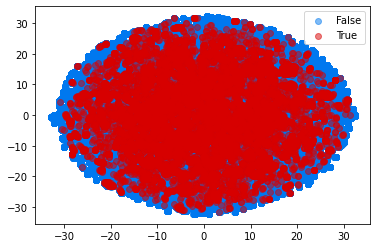

In [8]:
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)
# projected = pca.fit_transform(X_train_f)
# projected = TSNE(n_components=2).fit_transform(projected)

# cluster_colors = {0: '#0078ef', 1: '#d80000'}

# for g in np.unique(y_train):
#     idx = np.where(y_train == g)
#     plt.scatter(projected[idx, 0], projected[idx, 1], 
#             alpha=0.5, color=cluster_colors[g], label = g)

# plt.legend()
# plt.show()

### 0.1 Convert categorical features

### 0.1.1 missing value : KNN ,categorical features : mode

print(sklearn.__version__)

In [13]:
### 3400 of 780,000 data, could be deleted , practise to fill in 

# X_train[ 'acqCountry'].fillna(X_train[ 'acqCountry'].mode()[0],inplace =True)
# X_train[ 'posEntryMode'].fillna(X_train[ 'posEntryMode'].mode()[0],inplace =True)
# X_train[ 'posConditionCode'].fillna(X_train[ 'posConditionCode'].mode()[0],inplace =True)
# X_train[ 'transactionType'].fillna(X_train[ 'transactionType'].mode()[0],inplace =True)
# X_train[ 'merchantCountryCode'].fillna(X_train[ 'merchantCountryCode'].mode()[0],inplace =True)


# X_test[ 'acqCountry'].fillna(X_test[ 'acqCountry'].mode()[0],inplace =True)
# X_test[ 'posEntryMode'].fillna(X_test[ 'posEntryMode'].mode()[0],inplace =True)
# X_test[ 'posConditionCode'].fillna(X_test[ 'posConditionCode'].mode()[0],inplace =True)
# X_test[ 'transactionType'].fillna(X_test[ 'transactionType'].mode()[0],inplace =True)
# X_test[ 'merchantCountryCode'].fillna(X_test[ 'merchantCountryCode'].mode()[0],inplace =True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### 0.1.2 convert normal categorical features - get_dummies()

In [14]:
### convert some of the categorical features to dummy variables 
### one hot encoding 

# X_train_new = pd.get_dummies(X_train,columns=['acqCountry','posEntryMode','merchantCountryCode','merchantCategoryCode','posConditionCode','transactionType','cardPresent','expirationDateKeyInMatch','CVV_correct'])
# X_test_new = pd.get_dummies(X_test,columns=['acqCountry','posEntryMode','merchantCountryCode','merchantCategoryCode','posConditionCode','transactionType','cardPresent','expirationDateKeyInMatch','CVV_correct'])

# print('x_train_new:', X_train_new.shape, 'x_test_new:',X_test_new.shape)

x_train_new: (589772, 51) x_test_new: (196591, 51)


### 0.1.3 categorical features with high cadinality - value_counts()

In [15]:
# X_t_merchantName = X_train['merchantName'].value_counts(dropna=False)
# X_train_new['n_merchantName'] = X_train_new['merchantName'].map(X_t_merchantName)

# X_train_new = X_train_new.drop(['merchantName'],axis =1)

# ## X_test 
# X_t_merchantName = X_test['merchantName'].value_counts(dropna=False)
# X_test_new['n_merchantName'] = X_test_new['merchantName'].map(X_t_merchantName)

# X_test_new = X_test_new.drop(['merchantName'],axis =1)

# X_test_new.head()

,creditLimit,availableMoney,transactionAmount,currentBalance,balance_limit_ratio,days_after_signup,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,...,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL,cardPresent_N,cardPresent_Y,expirationDateKeyInMatch_N,expirationDateKeyInMatch_Y,CVV_correct_N,CVV_correct_Y,n_merchantName
547781,1000,565.08,178.54,434.92,0.43492,293.0,0,0,0,1,...,0,1,0,1,0,1,0,0,1,278
749738,1000,381.61,186.17,618.39,0.61839,4833.0,0,0,0,1,...,0,1,0,0,1,1,0,0,1,22
730894,5000,1883.05,65.47,3116.95,0.62339,2714.0,0,0,0,1,...,0,1,0,0,1,1,0,0,1,23
382145,2500,1956.90,125.63,543.10,0.21724,868.0,0,0,0,1,...,0,1,0,0,1,1,0,0,1,213
675808,500,27.33,273.13,472.67,0.94534,2128.0,0,0,0,1,...,0,1,0,1,0,1,0,0,1,4223


### 0.2 Numerical features - MinMaxScaler() transformation

In [16]:
# mm_scaler = preprocessing.MinMaxScaler().fit(X_train_new[num_cols])
# X_train_new[num_cols] = mm_scaler.transform(X_train_new[num_cols])


# mm_scaler_test = preprocessing.MinMaxScaler().fit(X_test_new[num_cols])
# X_test_new[num_cols] = mm_scaler_test.transform(X_test_new[num_cols])
# X_test_new.head()

,creditLimit,availableMoney,transactionAmount,currentBalance,balance_limit_ratio,days_after_signup,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,...,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL,cardPresent_N,cardPresent_Y,expirationDateKeyInMatch_N,expirationDateKeyInMatch_Y,CVV_correct_N,CVV_correct_Y,n_merchantName
547781,0.015075,0.029366,0.093707,0.009156,0.092101,0.029235,0,0,0,1,...,0,1,0,1,0,1,0,0,1,278
749738,0.015075,0.025764,0.097712,0.013019,0.130954,0.483781,0,0,0,1,...,0,1,0,0,1,1,0,0,1,22
730894,0.095477,0.055244,0.034362,0.065622,0.132013,0.271626,0,0,0,1,...,0,1,0,0,1,1,0,0,1,23
382145,0.045226,0.056694,0.065937,0.011434,0.046004,0.086804,0,0,0,1,...,0,1,0,0,1,1,0,0,1,213
675808,0.005025,0.018808,0.143353,0.009951,0.200191,0.212956,0,0,0,1,...,0,1,0,1,0,1,0,0,1,4223


## Part 3 Model Training and Result Evaluation

### 3.0 Down-sampling majority class

#### using all features

In [10]:
X_train_f_cluster = pd.read_pickle('data/X_train_f_cluster')
X_test_f_cluster = pd.read_pickle('data/X_test_f_cluster')

y_train = pd.read_pickle('data/y_train')
y_test = pd.read_pickle('data/y_test')

In [620]:
# Class count
count_class_0, count_class_1 = X_train_f_cluster['isFraud'].value_counts()

# Divide by class
f_class_0 = X_train_f_cluster[X_train_f_cluster['isFraud'] == 0]
f_class_1 = X_train_f_cluster[X_train_f_cluster['isFraud'] == 1]

f_class_0_under = f_class_0.sample(count_class_1, random_state=1)
f_train_under = pd.concat([f_class_0_under, f_class_1], axis=0)

print('Random under-sampling:')
print(f_train_under['isFraud'].value_counts())

Random under-sampling:
0.000    9422
1.000    9422
Name: isFraud, dtype: int64


In [621]:
f_train_under.drop(['isFraud'], axis =1, inplace=True)
X_test_f_cluster.drop(['isFraud'], axis =1, inplace=True)

f_train_under.head()

,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,transactionAmount_log,availableMoney_log,currentBalance_log,balance_limit_ratio_log,transaction_balance_ratio_log,CVV_correct,domesticTransaction,merchantName_ratio,merchantName_0,merchantName_1,merchantName_2,merchantName_3,merchantName_4,merchantName_5,merchantName_6,merchantName_7,merchantName_8,merchantName_9,acqCountry_ratio,acqCountry_US,acqCountry_MEX,acqCountry_CAN,acqCountry_PR,posEntryMode_ratio,posEntryMode_09,posEntryMode_02,posEntryMode_80,posEntryMode_90,posEntryMode_nan,posConditionCode_ratio,posConditionCode_01,posConditionCode_99,posConditionCode_nan,merchantCategoryCode_ratio,merchantCategoryCode_0,merchantCategoryCode_1,merchantCategoryCode_2,merchantCategoryCode_3,merchantCategoryCode_4,merchantCategoryCode_5,transactionType_ratio,transactionType_PURCHASE,transactionType_REVERSAL,transactionType_nan,creditLimit_ratio,creditLimit_0,creditLimit_1,creditLimit_2,creditLimit_3,creditLimit_4,currentBalance_ratio,bin_balance_limit_ratio,transaction_balance_ratio_ratio,cluster_ratio,cluster_1.0,cluster_0.0,cluster_2.0,cluster_3.0
467798,-0.710,0.320,-0.523,0.000,0.000,0.690,-0.681,-0.117,0.080,0.163,1.000,1.000,0.288,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,2.863,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,-1.133,-0.656,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,1.001,0.000,-0.264,-0.459,1.232,-1.407,-1.125,0.157,0.235,-0.163,-0.029,-0.296,0.000,-0.403,-0.703,-1.408,1.140,-0.203,0.815,0.541,-0.890,1.043,-0.787,-0.395,-0.055
35783,-0.903,1.956,-0.698,0.000,0.000,1.280,-1.361,-3.375,-1.642,5.285,1.000,1.000,0.875,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,2.863,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,-1.133,-0.656,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,0.993,0.000,-0.264,-0.459,-0.812,0.711,0.889,0.157,0.235,-0.163,-0.029,-1.685,0.000,2.481,-0.703,-1.408,1.140,-2.059,-2.583,0.747,-0.400,-0.959,-0.787,2.529,-0.055
607895,-0.710,0.160,-0.375,1.000,0.000,0.593,-1.229,0.167,1.159,0.028,1.000,1.000,-0.731,-0.402,-0.255,-0.306,-0.447,-0.315,-0.265,-0.349,2.562,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,0.292,-0.656,1.737,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.448,0.000,-0.264,2.179,1.232,0.711,-1.125,0.157,0.235,-0.163,-0.029,-0.296,0.000,-0.403,-0.703,-1.408,1.140,0.296,0.815,0.541,-0.890,1.043,-0.787,-0.395,-0.055
537826,0.363,-0.555,1.158,1.000,0.000,-0.156,-0.121,0.978,1.071,-0.449,1.000,1.000,0.021,-0.402,-0.255,-0.306,-0.447,3.174,-0.265,-0.349,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,-1.133,-0.656,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.439,0.000,-0.264,-0.459,-0.812,0.711,-1.125,0.157,0.235,-0.163,-0.029,1.275,0.000,-0.403,-0.703,0.710,1.140,1.061,0.815,-1.698,-0.890,1.043,-0.787,-0.395,-0.055
596330,-0.710,0.786,-0.516,1.000,0.000,0.913,-0.701,-0.099,0.136,0.239,1.000,1.000,0.298,-0.402,-0.255,-0.306,-0.447,3.174,-0.265,-0.349,-0.390,-0.307,-0.262,-0.086,0.123,-0.063,-0.055,-0.044,-1.133,-0.656,-0.576,-0.141,-0.160,-0.072,0.254,0.500,-0.098,-0.022,-0.232,0.000,-0.264,-0.459,-0.812,-1.407,0.889,0.157,0.235,-0.163,-0.029,-0.296,0.000,-0.403,-0.703,-1.408,1.140,-0.203,0.815,0.541,1.244,-0.959,1.270,-0.395,-0.055


#### using reduced features

In [596]:
# X_train_pca.to_pickle('data/X_train_f_c_pca')
# X_test_pca.to_pickle('data/X_test_f_c_pca')

In [8]:
X_train_f_c_pca = pd.read_pickle('data/X_train_f_c_pca')
X_test_f_c_pca = pd.read_pickle('data/X_test_f_c_pca')

y_train = pd.read_pickle('data/y_train')
y_test = pd.read_pickle('data/y_test')

In [9]:
X_train_f_c_pca = pd.concat([X_train_f_c_pca, y_train], axis=1)

# Class count
count_class_0, count_class_1 = X_train_f_c_pca['isFraud'].value_counts()

# Divide by class
pca_class_0 = X_train_f_c_pca[X_train_f_c_pca['isFraud'] == 0]
pca_class_1 = X_train_f_c_pca[X_train_f_c_pca['isFraud'] == 1]

pca_class_0_under = pca_class_0.sample(count_class_1, random_state=1)
pca_train_under = pd.concat([pca_class_0_under, pca_class_1], axis=0)

print('Random under-sampling:')
print(pca_train_under['isFraud'].value_counts())

Random under-sampling:
0    9422
1    9422
Name: isFraud, dtype: int64


In [11]:
pca_train_under.drop(['isFraud'], axis =1, inplace=True)

pca_train_under.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
467798,-1.009,-0.563,-0.199,-1.108,1.538,-0.809,-1.384,-0.092,0.572,0.434,-0.947,1.618,0.036,-0.756,-1.599,-0.030,0.708,1.989,1.017,-0.410,0.677,-1.642,-0.039,0.085,-0.001,0.051,-0.023,-0.095,-0.684,-0.034,0.023,-0.221
35783,-3.952,6.699,-0.352,-1.545,-0.660,-0.594,-2.075,0.466,0.558,2.571,-0.293,0.497,-0.051,-0.945,-1.468,-0.097,0.729,1.818,1.225,-0.495,0.003,-0.630,0.013,0.034,0.097,0.092,-0.020,-0.748,-0.813,0.219,0.195,-0.338
607895,-1.323,-1.951,-0.127,-1.512,1.796,0.143,-0.727,-0.098,0.359,1.443,0.258,-1.382,-0.138,0.138,-0.359,-0.646,-1.560,1.047,-1.356,-0.497,0.156,-0.802,0.041,-0.011,-0.057,0.084,0.057,-0.386,0.554,0.109,-1.789,1.381
537826,0.579,-2.824,-0.121,-0.045,0.657,-1.140,0.002,-1.328,0.485,0.228,-0.112,-1.933,-0.295,-0.202,-0.638,-0.155,0.671,-0.759,0.988,2.511,-0.265,-1.370,-0.244,0.042,-0.101,-0.049,-0.017,0.811,-0.603,0.029,-0.397,-0.263
596330,1.243,1.517,-0.261,-1.004,0.925,0.797,-0.352,-1.167,0.355,1.014,0.318,-0.017,-0.126,0.343,-0.443,-0.193,0.665,-0.591,1.157,2.492,-0.201,-1.528,-0.126,0.011,0.058,0.029,-0.112,-0.093,-0.719,0.756,-1.164,-1.324


#### downsampling y_train

In [12]:
# Class count
count_class_0, count_class_1 = X_train_f_c_pca['isFraud'].value_counts()

# Divide by class
y_0 = y_train[y_train == 0]
y_1 = y_train[y_train == 1]

y_0_under = y_0.sample(count_class_1, random_state=1)
y_train_under = pd.concat([y_0_under, y_1], axis=0)

print('Random under-sampling:')
print(y_train_under.value_counts())

Random under-sampling:
0    9422
1    9422
Name: isFraud, dtype: int64


In [13]:
y_train_under.head()

467798    0
35783     0
607895    0
537826    0
596330    0
Name: isFraud, dtype: int64

### 3.1 Cross Validation to choose appropriate model

### 3.1 Logistic Regression, Random Forest, KNN, Xgboost

In [2]:
# pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Logistic Regression

In [60]:
# from sklearn.linear_model import LogisticRegression 
# from sklearn.neighbors import KNeighborsClassifier 
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier 
# from xgboost import XGBClassifier
# from sklearn import metrics
# from sklearn.metrics import make_scorer, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score

# ## logistic regression 

# Logistic_r = LogisticRegression()
# Logistic_r.fit(X_train_new, y_train)
# y_pred = Logistic_r.predict(X_test_new)

# cm = metrics.confusion_matrix(y_test, y_pred)
# cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
# print(cmDF)

# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test,y_pred)
# recall = recall_score(y_test,y_pred)
# f1_score= f1_score(y_test, y_pred)

# print(accuracy,precision,recall,f1_score)

        pred_0  pred_1
true_0  193596       0
true_1    2995       0
0.9847653249640116 0.0 0.0 0.0


C:\Users\ChutianZhao\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [295]:
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import make_scorer, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score

## logistic regression 

Logistic_r = LogisticRegression()
Logistic_r.fit(X_train_f, y_train)
y_pred = Logistic_r.predict(X_test_f)

cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1_score= f1_score(y_test, y_pred)

print(accuracy, precision, recall, f1_score)

/Users/nora/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


        pred_0  pred_1
true_0  193594       2
true_1    2994       1
0.9847602382611615 0.3333333333333333 0.000333889816360601 0.00066711140760507


#### with PCA features

In [300]:
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import make_scorer, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score

## logistic regression 

Logistic_r = LogisticRegression()
Logistic_r.fit(X_train_pca, y_train)
y_pred = Logistic_r.predict(X_test_pca)

cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1_score= f1_score(y_test, y_pred)

print(accuracy, precision, recall, f1_score)

        pred_0  pred_1
true_0  193593       3
true_1    2994       1
0.9847551515583114 0.25 0.000333889816360601 0.0006668889629876625


### SVM

#### PCA + downsampling

In [15]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import make_scorer, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score

svm = SVC(kernel='rbf')
svm.fit(pca_train_under, y_train_under)
y_pred = svm.predict(X_test_f_c_pca)

cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

# generate evaluation metrics
print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred)))
print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred)))
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred)))

        pred_0  pred_1
true_0  136679   56917
true_1     785    2210
recall_scoreis: : 0.7378964941569283
precision_score is: : 0.03737717117391378
accuracy_score is: : 0.7064870721447065


### Random Forest

In [20]:
### RF and the confusion matrix
# rf  = RandomForestClassifier()
# rf.fit(X_train_new, y_train)
# y_pred = rf.predict(X_test_new)
# cm = metrics.confusion_matrix(y_test, y_pred)
# cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
# print(cmDF)

# # generate class probabilities
# probs = rf.predict_proba(X_test_new)

# # generate evaluation metrics
# print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred)))
# print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred)))
# print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred)))
# print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
# #print("%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

        pred_0  pred_1
true_0  193596       0
true_1    2995       0
recall_scoreis: : 0.0
precision_score is: : 0.0
accuracy_score is: : 0.9847653249640116
roc_auc_score is: : 0.6881083038491842


C:\Users\ChutianZhao\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [308]:
### RF and the confusion matrix
rf  = RandomForestClassifier()
rf.fit(X_train_f, y_train)
y_pred = rf.predict(X_test_f)
cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

# generate class probabilities
probs = rf.predict_proba(X_test_f)

# generate evaluation metrics
print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred)))
print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred)))
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
# print("%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

        pred_0  pred_1
true_0  193524      72
true_1    2946      49
recall_scoreis: : 0.016360601001669448
precision_score is: : 0.4049586776859504
accuracy_score is: : 0.9846483307984597
roc_auc_score is: : 0.7450785400614488


In [309]:
def df_feature_score(cols, scores, absolute=False):
    df_scores = pd.DataFrame(scores)
    df_cols = pd.DataFrame(cols)
    df = pd.concat([df_cols, df_scores], axis=1)
    df.columns=['Specs','Score']
    return df.sort_values(['Score'], ascending=False) if absolute==False \
            else df.iloc[df['Score'].abs().argsort()[::-1]]


importance = rf.feature_importances_

df = df_feature_score(X_train_f.columns, importance)

df

,Specs,Score
5,transactionAmount_log,0.109
1,transactionAmount,0.109
7,currentBalance_log,0.106
2,currentBalance,0.105
6,availableMoney_log,0.105
8,balance_limit_ratio_log,0.102
9,transaction_balance_ratio_log,0.102
12,merchantName_ratio,0.047
55,currentBalance_ratio,0.015
49,creditLimit_ratio,0.014


#### downsampling (best recall)

In [622]:
### RF and the confusion matrix
rf  = RandomForestClassifier()
rf.fit(f_train_under, y_train_under)
y_pred = rf.predict(X_test_f_cluster)
cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

# generate class probabilities
probs = rf.predict_proba(X_test_f_cluster)

# generate evaluation metrics
print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred)))
print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred)))
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))

        pred_0  pred_1
true_0  139047   54549
true_1     770    2225
recall_scoreis: : 0.7429048414023373
precision_score is: : 0.03919047451298129
accuracy_score is: : 0.7186086850364463
roc_auc_score is: : 0.7987900788592983


#### with PCA features

In [302]:
### RF and the confusion matrix
rf  = RandomForestClassifier()
rf.fit(X_train_pca, y_train)
y_pred = rf.predict(X_test_pca)
cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

# generate class probabilities
probs = rf.predict_proba(X_test_pca)

# generate evaluation metrics
print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred)))
print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred)))
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))

        pred_0  pred_1
true_0  193426     170
true_1    2908      87
recall_scoreis: : 0.02904841402337229
precision_score is: : 0.33852140077821014
accuracy_score is: : 0.984343128627455
roc_auc_score is: : 0.7305781947646445


In [306]:
importance = rf.feature_importances_

importance

array([0.03306887, 0.04239562, 0.03024103, 0.03584113, 0.03314587,
       0.03389997, 0.03423507, 0.03171164, 0.03257684, 0.03191166,
       0.03283666, 0.03331148, 0.03291426, 0.03326878, 0.03169842,
       0.03166304, 0.02970121, 0.03184794, 0.03104378, 0.03110002,
       0.03184773, 0.03106694, 0.03171463, 0.0299395 , 0.02975374,
       0.02867214, 0.03041868, 0.03183104, 0.03246452, 0.03151059,
       0.03236723])

#### downsampling + with PCA features

In [615]:
### RF and the confusion matrix
rf  = RandomForestClassifier()
rf.fit(pca_train_under, y_train_under)
y_pred = rf.predict(X_test_f_c_pca)
cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

# generate class probabilities
probs = rf.predict_proba(X_test_f_c_pca)

# generate evaluation metrics
print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred)))
print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred)))
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))

        pred_0  pred_1
true_0  138120   55476
true_1     828    2167
recall_scoreis: : 0.7235392320534224
precision_score is: : 0.037593463213226236
accuracy_score is: : 0.7135982827291178
roc_auc_score is: : 0.7859981473216465


### Xgboost

In [30]:
### Train XGB and the confusion matrix
# xgb = XGBClassifier()
# xgb.fit(X_train_new, y_train)

# y_pred = xgb.predict(X_test_new)
# probs = xgb.predict_proba(X_test_new)

# cm = metrics.confusion_matrix(y_test, y_pred)
# cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
# print(cmDF)

# # generate evaluation metrics
# print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred)))
# print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred)))
# print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred)))
# print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


        pred_0  pred_1
true_0  193596       0
true_1    2994       1
recall_scoreis: : 0.000333889816360601
precision_score is: : 1.0
accuracy_score is: : 0.9847704116668616
roc_auc_score is: : 0.7548992918526684


In [298]:
### Train XGB and the confusion matrix
xgb = XGBClassifier()
xgb.fit(X_train_f, y_train)

y_pred = xgb.predict(X_test_f)
probs = xgb.predict_proba(X_test_f)

cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

# generate evaluation metrics
print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred)))
print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred)))
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))

/Users/nora/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
        pred_0  pred_1
true_0  193568      28
true_1    2957      38
recall_scoreis: : 0.012687813021702838
precision_score is: : 0.5757575757575758
accuracy_score is: : 0.9848161919925124
roc_auc_score is: : 0.8170362132373422


#### with PCA feature

In [303]:
### Train XGB and the confusion matrix
xgb = XGBClassifier()
xgb.fit(X_train_pca, y_train)

y_pred = xgb.predict(X_test_pca)
probs = xgb.predict_proba(X_test_pca)

cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

# generate evaluation metrics
print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred)))
print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred)))
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))

/Users/nora/miniconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
        pred_0  pred_1
true_0  193546      50
true_1    2949      46
recall_scoreis: : 0.015358931552587647
precision_score is: : 0.4791666666666667
accuracy_score is: : 0.9847449781526113
roc_auc_score is: : 0.8078295321710347


### 3.2 Penalized Models

Penalized classification imposes an additional cost on the model for making classification mistakes on the minority class during training. These penalties can bias the model to pay more attention to the minority class.

Using penalization is desirable if you are locked into a specific algorithm and are unable to resample or you’re getting poor results. It provides yet another way to “balance” the classes. 

Setting up the penalty matrix can be complex. You will very likely have to try a variety of penalty schemes and see what works best for your problem.

### Failure Analysis

In [39]:
y_test.value_counts()

False    193596
True       2995
Name: isFraud, dtype: int64

In [ ]:
# Use 5-fold Cross Validation to get scores for all models

#model_names = ['KNN','SVM','xgboost']
#model_list = [knn, svm, xgb]


cv_score = model_selection.cross_val_score(xgb, X_train_new, y_train,cv=5)
print('xgboost', cv_score)
print('Model accuracy of ' + 'xgboost' + ' is ' + str(cv_score.mean()))

cm = metrics.confusion_matrix(y_test, y_pred_sm)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

### 3.2 Treat imbalance data : upsampling  - SMOTE

In [26]:
pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in c:\programdata\anaconda3\lib\site-packages (0.8.0)
Note: you may need to restart the kernel to use updated packages.


In [46]:
y_train.value_counts()

False    580350
True       9422
Name: isFraud, dtype: int64

In [23]:
import imblearn
from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state =12) 

X_train_sm,y_train_sm = smt.fit_resample( X_train_new, y_train)
unique, counts = np.unique(y_train_sm, return_counts=True)
print(np.asarray((unique, counts)).T)



[[     0 580350]
 [     1 580350]]


### 3.3 Train models with SOMTE data 

In [24]:
### Train RF on Smote data 
rf_sm  = RandomForestClassifier()
rf_sm.fit(X_train_sm, y_train_sm)

y_pred_sm = rf.predict(X_test_new)
cm = metrics.confusion_matrix(y_test, y_pred_sm)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)



        pred_0  pred_1
true_0  193596       0
true_1    2995       0


In [29]:
### Train XGB on Smote data 
xgb_sm  = XGBClassifier()
xgb_sm.fit(X_train_sm, y_train_sm)

y_pred_sm = xgb_sm.predict(X_test_new)
probs = xgb_sm.predict_proba(X_test_new)

cm = metrics.confusion_matrix(y_test, y_pred_sm)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)


# generate evaluation metrics
print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred_sm)))
print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred_sm)))
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred_sm)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


        pred_0  pred_1
true_0  187561    6035
true_1    2606     389
recall_scoreis: : 0.1298831385642738
precision_score is: : 0.06055417185554172
accuracy_score is: : 0.9560458006724621
roc_auc_score is: : 0.7146661139779202


### 3.4  Hyperparameters tuning by GridSearchCV

In [ ]:
score = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)
        }

In [65]:
## grid search function  
from sklearn.model_selection import GridSearchCV

def grid_search_func(model,paramters):

    grid_search = GridSearchCV(model, param_grid=paramters , scoring = "recall", cv = 3)
    grid_search.fit(X_train_sm, y_train_sm)

    y_pred = grid_search.predict(X_test_new)
    y_prob = grid_search.predict_proba(X_test_new)

    print(grid_search.best_params_)

    cm = metrics.confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)

    # generate evaluation metrics
    print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred_sm)))
    print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred_sm)))
    print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred_sm)))
    print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))



In [52]:
# LR 
# C: inverse of regularization strength, smaller values specify stronger regularization
# "C" : np.logspace(-2,2,5)

LRGrid = {'C': [0.01, 0.1, 1, 10], "penalty":["l1","l2"]}    # l1 lasso l2 ridge
Logreg = LogisticRegression()

grid_search_LR_f1 = grid_search_func(Logreg, LRGrid )


AttributeError: 'numpy.float64' object has no attribute '__name__'

In [45]:
### RF  

parameters = {        
'max_depth': [None, 5, 15],
'n_estimators' :  [10,30,50],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}

rf_grid = RandomForestClassifier(random_state=0)

grid_search_rf_f1 = grid_search_func(rf_grid, parameters, refit_score='f1_score')


AttributeError: 'numpy.float64' object has no attribute '__name__'

In [70]:
### xgb   

parameters = {        
'max_depth': [5, 15],
'n_estimators' :  [10,30]
}

xgb_grid = XGBClassifier(random_state=0)

grid_search_xgb = grid_search_func(xgb_grid, parameters)

### finalize the best performance model based on given grid search scoring (recall, percison, f1)
best_xgb = grid_search_xgb.best_estimator_

best_xgb

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:08:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:08:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:09:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:09:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:09:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:09:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:10:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:10:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:11:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:11:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:12:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:14:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:15:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


{'max_depth': 15, 'n_estimators': 30}
        pred_0  pred_1
true_0  189592    4004
true_1    2759     236
recall_scoreis: : 0.1298831385642738
precision_score is: : 0.06055417185554172
accuracy_score is: : 0.9560458006724621
roc_auc_score is: : 0.7548992918526684


AttributeError: 'NoneType' object has no attribute 'best_estimator_'

In [69]:
best_xgb = grid_search_xgb.best_estimator_

best_xgb

AttributeError: 'NoneType' object has no attribute 'best_estimator_'

## Part 4 Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

In [ ]:
## Xgb: use best model from grid search to predict y_test
  
y_test_pred = best_xgb.predict(X_test_new)
y_test_pred_prob = best_xgb.predict_proba(X_test_new)

cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

        # generate evaluation metrics
print("%s: %r" % ("recall_scoreis: ", recall_score(y_test, y_pred_sm)))
print("%s: %r" % ("precision_score is: ", precision_score(y_test, y_pred_sm)))
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, y_pred_sm)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))


In [ ]:
## Rf




## Part 5  use model for feature selection